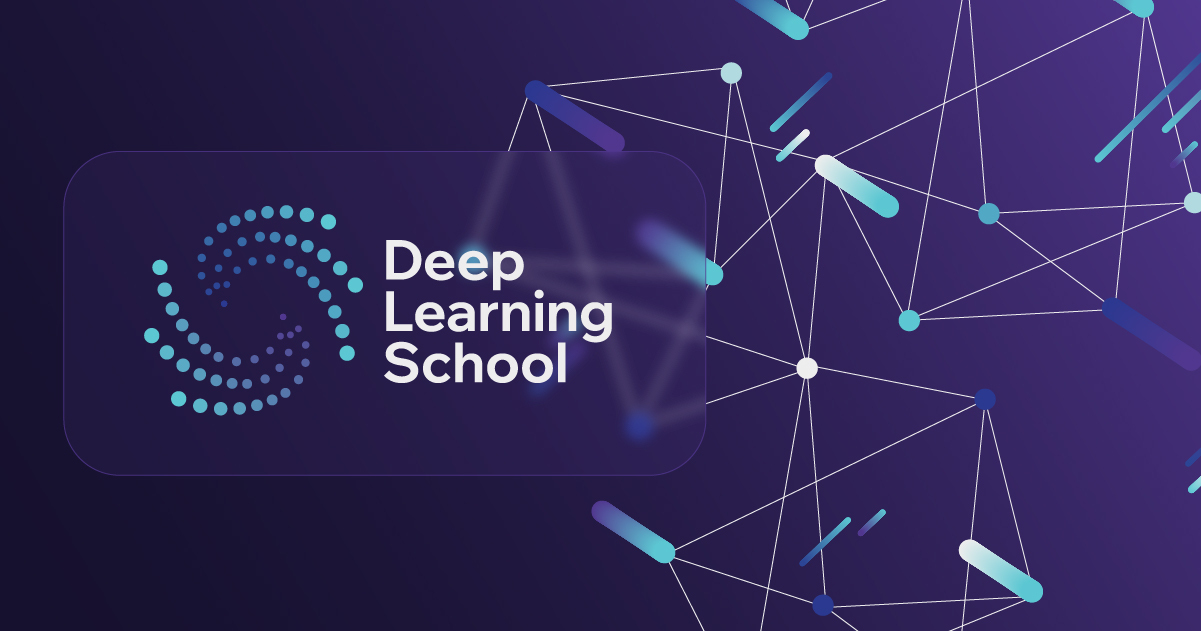


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [84]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import transforms
import random
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import math
import imageio
from PIL import Image
import kagglehub

%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [2]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [3]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [4]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [5]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [6]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
from sklearn.model_selection import train_test_split

images_train, images_val, attrs_train, attrs_val = train_test_split(images, attrs, test_size=0.2)
attrs_train.reset_index(inplace=True)
attrs_val.reset_index(inplace=True)

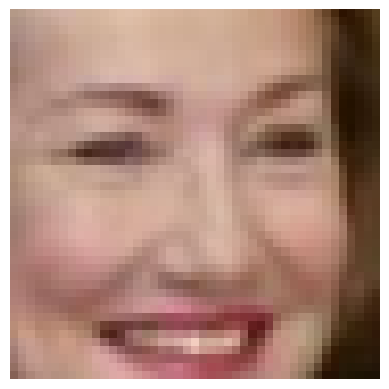

In [8]:
def show_numpy_image(image_array, title=None):
  plt.figure()
  plt.imshow(image_array)
  plt.axis('off')
  if title:
    plt.title(title)
  plt.show()

show_numpy_image(images_train[2])

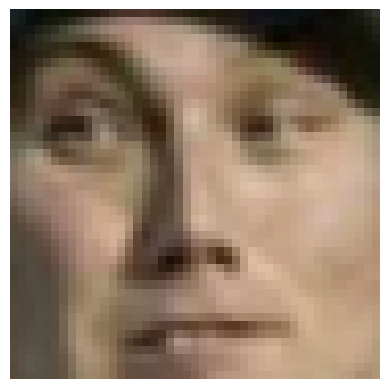

In [9]:
show_numpy_image(images_val[51])

In [10]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.ToTensor(),
  #  transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
   # transforms.Normalize(mean, std),
])


class ImageDataset(Dataset):
        def __init__(self, images, transform=None):
            self.images = images
            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = self.images[idx]
            if self.transform:
                image = self.transform(image)
            return image

train_dataset = ImageDataset(images_train, transform=train_transform)
val_dataset = ImageDataset(images_val, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



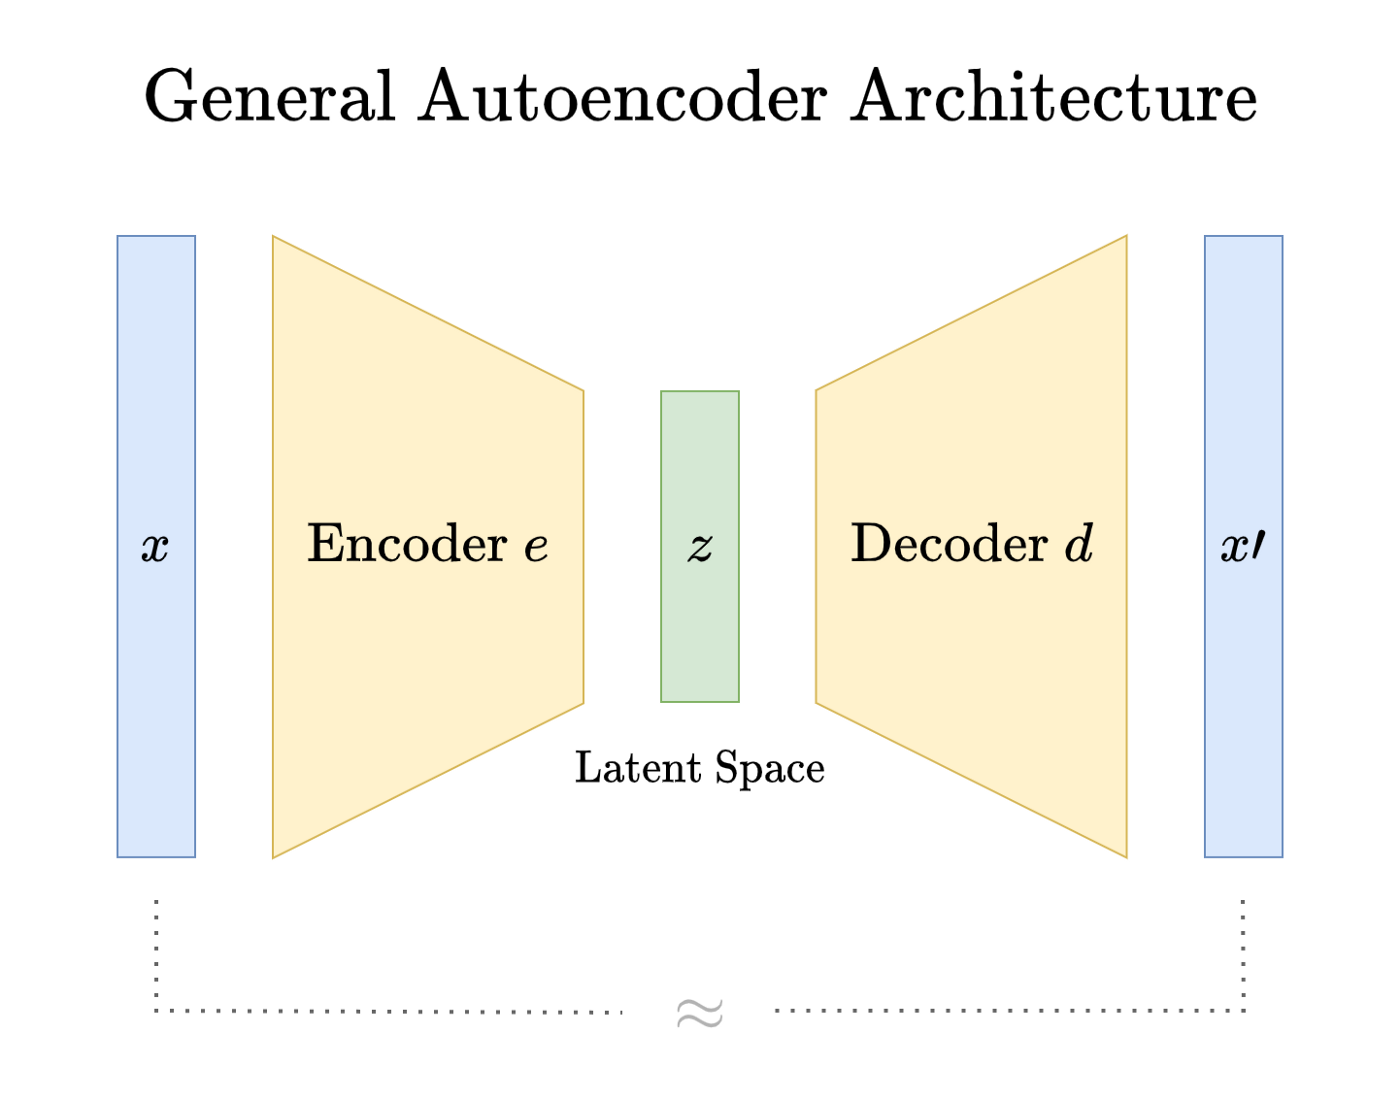

In [11]:
dim_code = 16 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [12]:
class VAE(nn.Module):
    def __init__(self, input_channels=1, img_h=28, img_w=28, z_dim=8):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.img_h = img_h
        self.img_w = img_w
        self.input_channels = input_channels
        self.z_dim = z_dim
        
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2), # B, 32, 23, 23 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # B, 64, 12, 12
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # B, 128, 6, 6
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        # --- Декодер ---
        self.conv_decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # B, 64, 12, 12
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0), # B, 32, 23, 23
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=2, padding=2, output_padding=0), # B, 3, 45, 45
            nn.Sigmoid()
        )

        self.flattened_size = self._get_conv_output_size(input_channels, img_h, img_w)

        # Энкодер - Bottleneck
        self.fc_encoder = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim * 2)
        )

        # Декодер - Bottleneck
        self.fc_decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.flattened_size),
            nn.ReLU()
        )

    def _get_conv_output_size(self, input_channels, h, w):
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, h, w)
            output = self.conv_encoder(dummy_input)
            self.conv_output_shape = output.shape
            return int(np.prod(output.shape[1:]))

    def encode(self, x):
        x = self.conv_encoder(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_encoder(x)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        if self.training:
            return mu + eps * std
        else:
            return mu

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(x.size(0), *self.conv_output_shape[1:])
        reconstruction = self.conv_decoder(x)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [28]:
def train_lfw(model, optimizer, criterion, scheduler, train_loader, val_loader=None, num_epoch=10, show_img_every = 5):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epoch)):
        model.train()
        train_losses_per_epoch = []
        for batch in train_loader:
            optimizer.zero_grad()
            reconstructed, latent = model(batch.to(device))
            loss = criterion(reconstructed, batch.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))
        
        if val_loader is not None:
            model.eval()
            val_losses_per_epoch = []
            with torch.no_grad():
                for batch in val_loader:
                    reconstructed, _ = model(batch.to(device))
                    loss = criterion(reconstructed, batch.to(device))
                    val_losses_per_epoch.append(loss.item())
    
            val_losses.append(np.mean(val_losses_per_epoch))
            scheduler.step(val_losses[-1])
        else:
            val_losses.append(0)
            scheduler.step(train_losses[-1])
        
        print(f"Epoch: {epoch} Train loss: {train_losses[-1]} Val loss: {val_losses[-1]}")
        if epoch % show_img_every == 0:
            if val_loader is not None:
                batch_for_vis = next(iter(val_loader)).to(device)
            else:
                batch_for_vis = next(iter(train_loader)).to(device)
            with torch.no_grad():
                 reconstruction_vis, _ = model(batch_for_vis)
            idx_to_show = random.randint(0, batch_for_vis.shape[0] - 1)
            img_orig_tensor = batch_for_vis[idx_to_show]
            img_rec_tensor = reconstruction_vis[idx_to_show]

            img_orig_np = img_orig_tensor.cpu().detach().numpy().transpose(1, 2, 0)
            img_rec_np = img_rec_tensor.cpu().detach().numpy().transpose(1, 2, 0)
            img_orig_np = np.clip(img_orig_np, 0, 1)
            img_rec_np = np.clip(img_rec_np, 0, 1)
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            ax1, ax2 = axes

            ax1.imshow(img_orig_np)
            ax1.set_title('Original')
            ax1.axis('off')

            ax2.imshow(img_rec_np)
            ax2.set_title('Reconstructed')
            ax2.axis('off')

            plt.suptitle(f"Epoch {epoch+1}")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    return train_losses, val_losses



In [39]:
criterion = F.mse_loss
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = Autoencoder().to(device)

optimizer = optim.AdamW(autoencoder.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 Train loss: 0.012319537287931528 Val loss: 0.007509317017644417


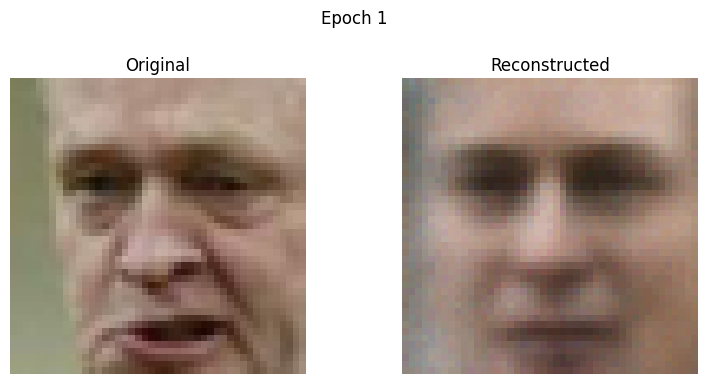

Epoch: 1 Train loss: 0.008274003934184605 Val loss: 0.00597115172183645
Epoch: 2 Train loss: 0.0073174061625629104 Val loss: 0.005809521130257849
Epoch: 3 Train loss: 0.006345993348214168 Val loss: 0.00544847676772511
Epoch: 4 Train loss: 0.005924923676581534 Val loss: 0.005460377276937356
Epoch: 5 Train loss: 0.005674235345976418 Val loss: 0.005268997623157718
Epoch: 6 Train loss: 0.005475442012284517 Val loss: 0.0052198865450918674
Epoch: 7 Train loss: 0.005339338874941024 Val loss: 0.004971047926348801
Epoch: 8 Train loss: 0.005215377219785791 Val loss: 0.0049450478072796235
Epoch: 9 Train loss: 0.00512302715983844 Val loss: 0.005130692136737215
Epoch: 10 Train loss: 0.005049356378787776 Val loss: 0.005038746956050804


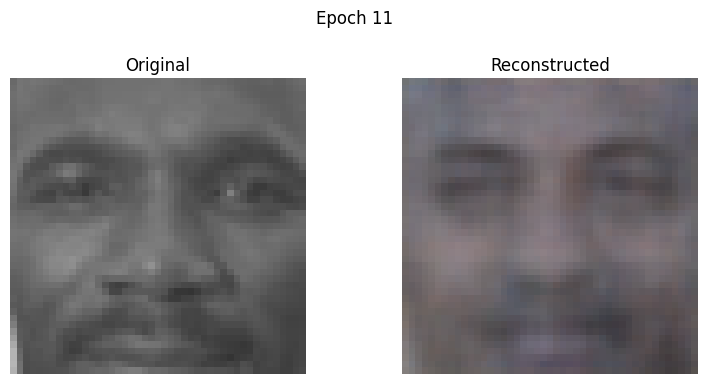

Epoch: 11 Train loss: 0.004952381288660382 Val loss: 0.00494810250604746
Epoch: 12 Train loss: 0.004906767419815353 Val loss: 0.0048518850514806785
Epoch: 13 Train loss: 0.004817249024989698 Val loss: 0.004755429576765349
Epoch: 14 Train loss: 0.004767362283774432 Val loss: 0.004798909126268559
Epoch: 15 Train loss: 0.004736879572060459 Val loss: 0.004811886595038409
Epoch: 16 Train loss: 0.004662726971063269 Val loss: 0.005072987820644577
Epoch: 17 Train loss: 0.00463496097494604 Val loss: 0.004828097767587242
Epoch: 18 Train loss: 0.004561789527772077 Val loss: 0.004774314099441546
Epoch: 19 Train loss: 0.0045353415574114694 Val loss: 0.004845077439075432
Epoch: 20 Train loss: 0.004280578391821314 Val loss: 0.004629553643148676


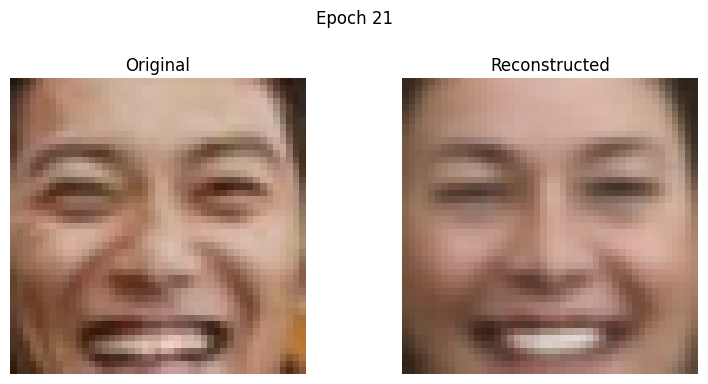

Epoch: 21 Train loss: 0.004239040594912864 Val loss: 0.00463347137823565
Epoch: 22 Train loss: 0.004197869375550014 Val loss: 0.004665108777633599
Epoch: 23 Train loss: 0.004162351903355067 Val loss: 0.004672669966940097
Epoch: 24 Train loss: 0.00414091620348768 Val loss: 0.00469864230556272
Epoch: 25 Train loss: 0.004094486809489747 Val loss: 0.004715365305327807
Epoch: 26 Train loss: 0.004065284733711885 Val loss: 0.0047048451858402816
Epoch: 27 Train loss: 0.003919143961248696 Val loss: 0.004786006044412434
Epoch: 28 Train loss: 0.003885442459098173 Val loss: 0.004680690841075588
Epoch: 29 Train loss: 0.0038657336966171803 Val loss: 0.004773738243090595
Epoch: 30 Train loss: 0.003842144229737337 Val loss: 0.004661780618567099


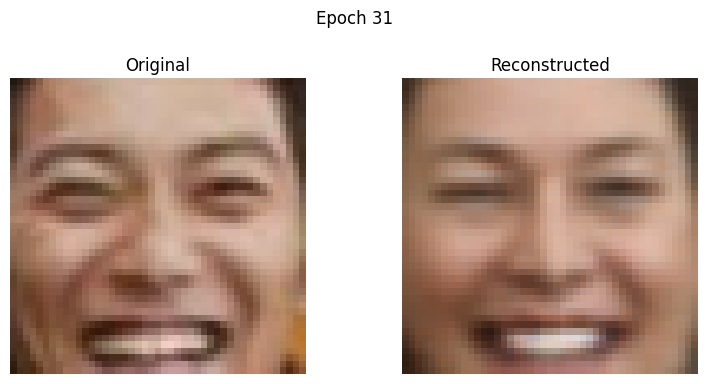

Epoch: 31 Train loss: 0.0038264420057249108 Val loss: 0.004755217354110581
Epoch: 32 Train loss: 0.0038023706328601335 Val loss: 0.0047982580843735426
Epoch: 33 Train loss: 0.0037354670161046243 Val loss: 0.00466071454826516
Epoch: 34 Train loss: 0.003725142931011596 Val loss: 0.0047049097215054745
Epoch: 35 Train loss: 0.0037097978494128304 Val loss: 0.0047200675752993365
Epoch: 36 Train loss: 0.003702603012288663 Val loss: 0.0047009395354775585
Epoch: 37 Train loss: 0.0036923119744899503 Val loss: 0.004636040179619401
Epoch: 38 Train loss: 0.0036839351542265687 Val loss: 0.004675089522819728
Epoch: 39 Train loss: 0.00364727044946377 Val loss: 0.004695052509606564
Epoch: 40 Train loss: 0.003642706575011002 Val loss: 0.0046641018038536325


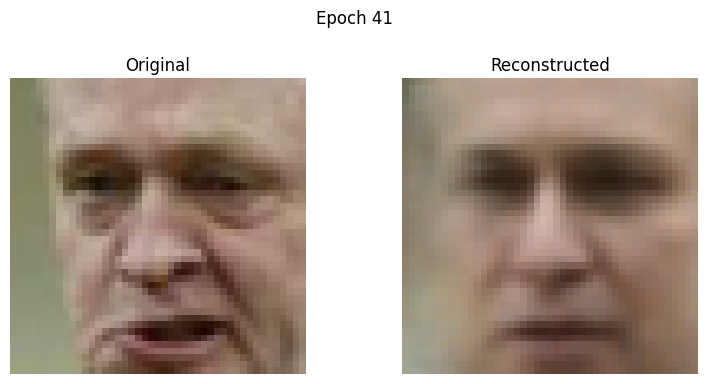

Epoch: 41 Train loss: 0.0036386342324385935 Val loss: 0.004668341411736237
Epoch: 42 Train loss: 0.003633556284928626 Val loss: 0.004671815005031989
Epoch: 43 Train loss: 0.003630297906330502 Val loss: 0.004656193985626396
Epoch: 44 Train loss: 0.0036250871086132507 Val loss: 0.004745688911111272
Epoch: 45 Train loss: 0.003608260621984846 Val loss: 0.004702391205525371
Epoch: 46 Train loss: 0.0036038611189257845 Val loss: 0.004693624524238284
Epoch: 47 Train loss: 0.003604308411965381 Val loss: 0.0046869971213358425
Epoch: 48 Train loss: 0.0035986423400503832 Val loss: 0.004677486820903672
Epoch: 49 Train loss: 0.003597230243628732 Val loss: 0.004679195740858891
Epoch: 50 Train loss: 0.003594973293186572 Val loss: 0.004673329596499711


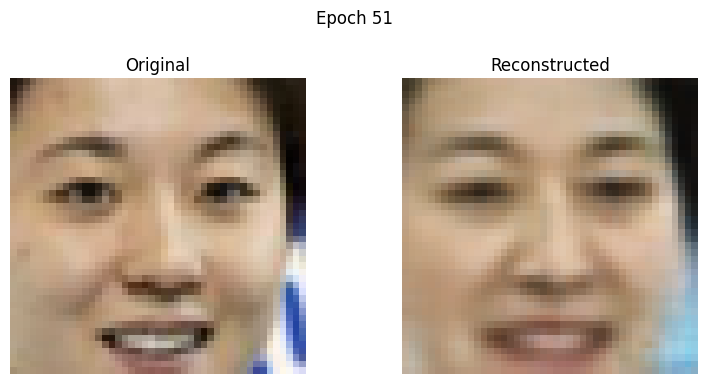

Epoch: 51 Train loss: 0.0035860735076217822 Val loss: 0.004668051321561927
Epoch: 52 Train loss: 0.003588612805028188 Val loss: 0.004677090636032738
Epoch: 53 Train loss: 0.0035841021239640634 Val loss: 0.00466213963138885
Epoch: 54 Train loss: 0.003580382393836726 Val loss: 0.004670607435444829
Epoch: 55 Train loss: 0.0035786919860639026 Val loss: 0.004671643971108851
Epoch: 56 Train loss: 0.0035810516316910584 Val loss: 0.004695005452339637
Epoch: 57 Train loss: 0.003577150432040476 Val loss: 0.004675806787163642
Epoch: 58 Train loss: 0.0035761009518995163 Val loss: 0.004665659523482709
Epoch: 59 Train loss: 0.003576450367993436 Val loss: 0.004679354945534563
Epoch: 60 Train loss: 0.003572343377980622 Val loss: 0.004676248259894765


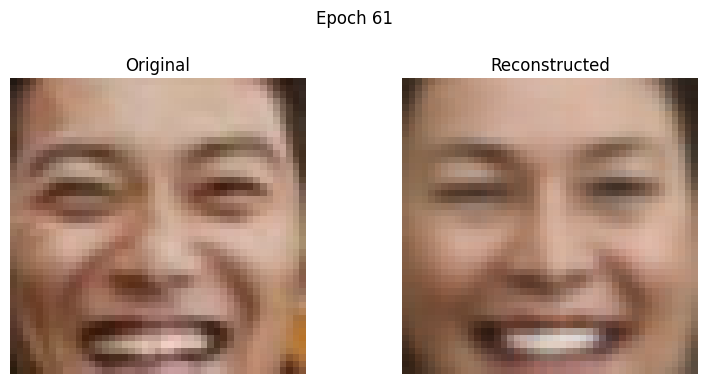

Epoch: 61 Train loss: 0.0035725656980343983 Val loss: 0.004689134161998617
Epoch: 62 Train loss: 0.0035729755877477133 Val loss: 0.00468159903380114
Epoch: 63 Train loss: 0.0035691496289270365 Val loss: 0.004696563969006745
Epoch: 64 Train loss: 0.003569322511347945 Val loss: 0.00466077283766449
Epoch: 65 Train loss: 0.0035694087794409784 Val loss: 0.004682125597817138
Epoch: 66 Train loss: 0.0035703922068833394 Val loss: 0.004671921002774819
Epoch: 67 Train loss: 0.003569998452980135 Val loss: 0.004685417864164536
Epoch: 68 Train loss: 0.003568885416494234 Val loss: 0.0047058699455106556
Epoch: 69 Train loss: 0.0035687515296636396 Val loss: 0.004665486263337695
Epoch: 70 Train loss: 0.003568015937954145 Val loss: 0.004662453309465822


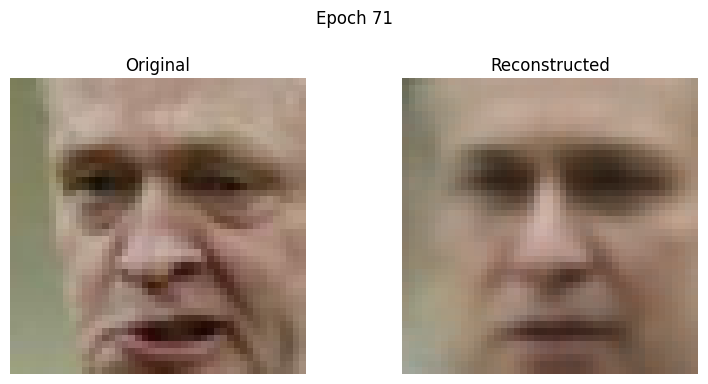

Epoch: 71 Train loss: 0.003566042789424206 Val loss: 0.004667728530005254
Epoch: 72 Train loss: 0.0035672553536153055 Val loss: 0.004691089561851667
Epoch: 73 Train loss: 0.0035663263015601374 Val loss: 0.004660038238406849
Epoch: 74 Train loss: 0.0035665795537715757 Val loss: 0.0046931523387391105
Epoch: 75 Train loss: 0.003565917009731826 Val loss: 0.004692851966154963
Epoch: 76 Train loss: 0.00356646739759441 Val loss: 0.0046675370556392955
Epoch: 77 Train loss: 0.003562805949564713 Val loss: 0.004689459041423393
Epoch: 78 Train loss: 0.0035661239317891437 Val loss: 0.0046830370521178544
Epoch: 79 Train loss: 0.003565920015452334 Val loss: 0.004674103497428463
Epoch: 80 Train loss: 0.0035651629603708416 Val loss: 0.004693925722875834


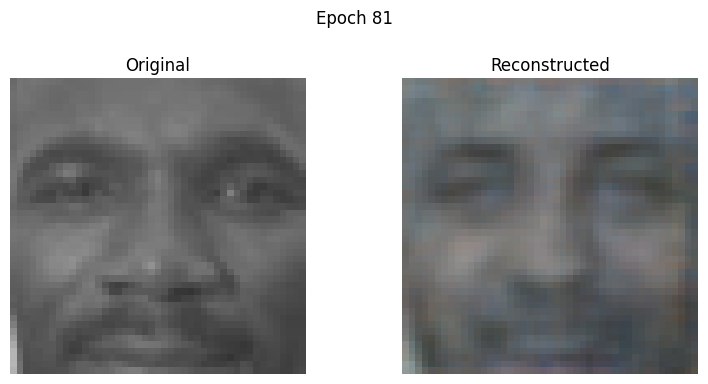

Epoch: 81 Train loss: 0.003564509113073723 Val loss: 0.004716798214108816
Epoch: 82 Train loss: 0.003566471116951025 Val loss: 0.004689711022387488
Epoch: 83 Train loss: 0.003564555807485142 Val loss: 0.004684478180386737
Epoch: 84 Train loss: 0.0035647274299725586 Val loss: 0.004679787836970314
Epoch: 85 Train loss: 0.003562238151035755 Val loss: 0.004679756628110224
Epoch: 86 Train loss: 0.0035657330499214504 Val loss: 0.004718310311847115
Epoch: 87 Train loss: 0.0035655478416464176 Val loss: 0.004668292528270294
Epoch: 88 Train loss: 0.0035639311981905705 Val loss: 0.004701939232415296
Epoch: 89 Train loss: 0.003561843796989205 Val loss: 0.004696165011929614
Epoch: 90 Train loss: 0.0035640308076388973 Val loss: 0.004669116217095269


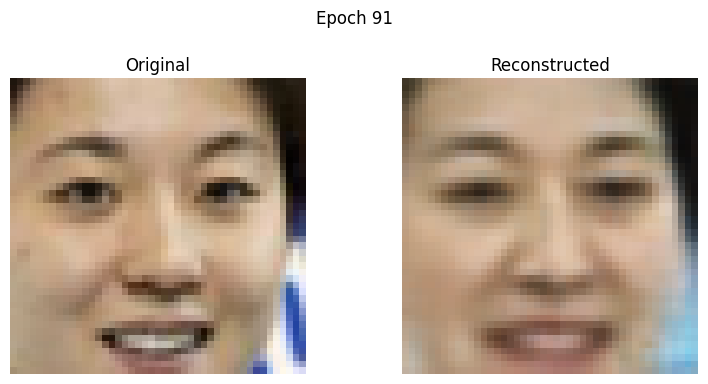

Epoch: 91 Train loss: 0.0035677108679500968 Val loss: 0.004721045792371737
Epoch: 92 Train loss: 0.0035653401064973775 Val loss: 0.004701857318490246
Epoch: 93 Train loss: 0.0035642577968814123 Val loss: 0.004687472088771977
Epoch: 94 Train loss: 0.0035616992371452255 Val loss: 0.004699240367870925
Epoch: 95 Train loss: 0.003562129866276907 Val loss: 0.004692346437927619
Epoch: 96 Train loss: 0.003565581384314718 Val loss: 0.00471324382645664
Epoch: 97 Train loss: 0.003564567180274613 Val loss: 0.0047266422356917635
Epoch: 98 Train loss: 0.003564212503527727 Val loss: 0.004687494088437034
Epoch: 99 Train loss: 0.0035652344420795978 Val loss: 0.004666545367297238


In [40]:
train_loss, val_loss = train_lfw(autoencoder, optimizer, criterion, scheduler, train_loader, val_loader, num_epoch=100, show_img_every=10)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

In [16]:
def show_reconstructions_from_loader(model, loader, device, n_images=5, figsize=(8, None), main_title="Original vs. Reconstructed Images"):
    model.eval()
    orig_images = []
    recon_images = []

    with torch.no_grad():
        images_collected = 0
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                batch_images = batch[0].to(device)
            else:
                batch_images = batch.to(device)

            reconstruction, _ = model(batch_images)
            batch_size = batch_images.shape[0]
            needed_now = n_images - images_collected
            take_from_batch = min(batch_size, needed_now)

            orig_images.extend(batch_images[:take_from_batch])
            recon_images.extend(reconstruction[:take_from_batch])

            images_collected += take_from_batch

            if images_collected >= n_images:
                break

    fig_w, fig_h = figsize
    if fig_h is None:
       fig_h = 2.5 * n_images
    fig, axes = plt.subplots(n_images, 2, figsize=(fig_w, fig_h))

    if n_images == 1:
        axes = np.array([axes]) # Делаем его (1, 2)

    for i in range(n_images):
        orig_tensor = orig_images[i]
        recon_tensor = recon_images[i]

        img_orig_np = orig_tensor.cpu().detach().numpy()
        if img_orig_np.shape[0] in [1, 3]:
             img_orig_np = img_orig_np.transpose(1, 2, 0)
        img_orig_np = np.clip(img_orig_np, 0, 1)

        img_rec_np = recon_tensor.cpu().detach().numpy()
        if img_rec_np.shape[0] in [1, 3]:
             img_rec_np = img_rec_np.transpose(1, 2, 0)
        img_rec_np = np.clip(img_rec_np, 0, 1)


        ax_orig = axes[i, 0]
        ax_orig.imshow(img_orig_np)
        ax_orig.axis('off')
        if i == 0:
            ax_orig.set_title('Original')

        # Отображаем реконструкцию
        ax_rec = axes[i, 1]
        ax_rec.imshow(img_rec_np)
        ax_rec.axis('off')
        if i == 0:
            ax_rec.set_title('Reconstructed')

    if main_title:
        fig.suptitle(main_title, fontsize=14)

    plt.tight_layout(rect=[0, 0.01, 1, 0.96] if main_title else None)
    plt.show()


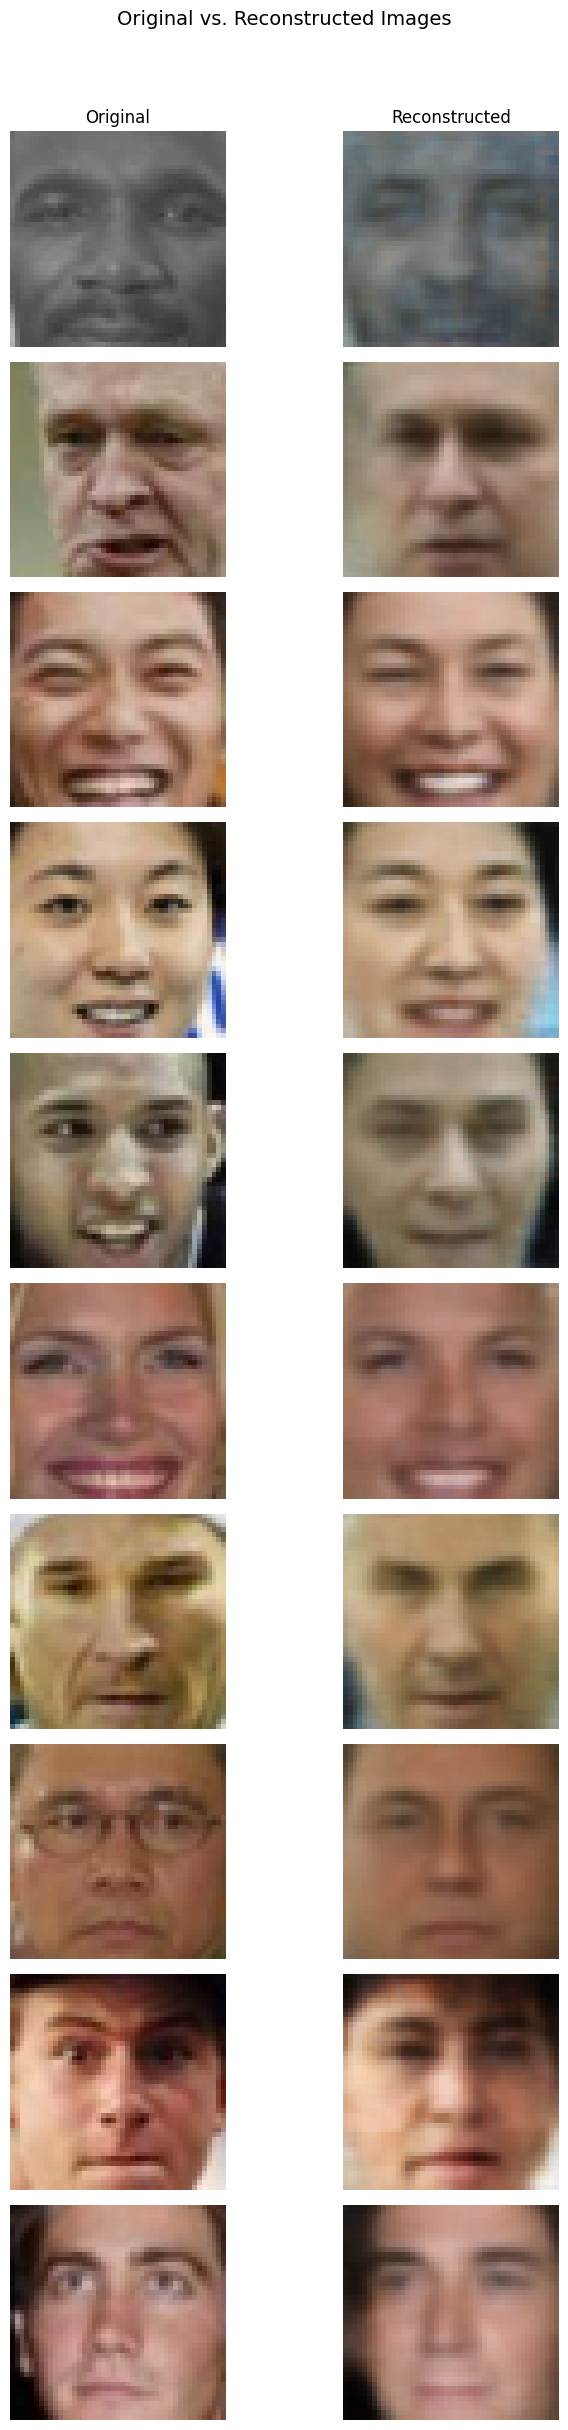

In [43]:
show_reconstructions_from_loader(autoencoder, val_loader, device, 10)

Что вы можете сказать про результат?

В принципе лица достаточно хорошо выглядят, бывают конечно искажения, немного мыльно, но скорее всего это из за недостаточного обучения и простой модели
но я поугарал неплохо)

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [44]:
autoencoder.eval()
all_latents = []
with torch.no_grad():
    for batch in tqdm(train_loader): # Или val_loader
         if isinstance(batch, (list, tuple)): batch=batch[0]
         batch = batch.to(device)
         latent = autoencoder.encode(batch)
         if latent.dim() > 2:
             latent = latent.view(latent.size(0), -1) # Flatten
         all_latents.append(latent.cpu().numpy())
real_latents = np.concatenate(all_latents, axis=0)
print(f"Shape of real latents: {real_latents.shape}")

  0%|          | 0/2629 [00:00<?, ?it/s]

Shape of real latents: (10514, 32)


In [17]:
def show_generated_images(images_tensor, n_to_show=10, figsize=(10, None), title="Generated Images"):
    actual_n = min(n_to_show, images_tensor.shape[0])
    cols = 5
    rows = math.ceil(actual_n / cols)
    fig_w, fig_h = figsize
    if fig_h is None: fig_h = rows * 2.5

    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = axes.flatten()

    for i in range(actual_n):
        img_tensor = images_tensor[i]
        img_np = img_tensor.cpu().detach().numpy()
        if img_np.ndim == 3 and img_np.shape[0] in [1, 3]:
            img_np = img_np.transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        ax = axes[i]
        ax.imshow(img_np)
        ax.axis('off')

    for j in range(actual_n, len(axes)):
        axes[j].axis('off')

    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.01, 1, 0.96] if title else None)
    plt.show()


In [45]:
mu_real = np.mean(real_latents, axis=0)
std_real = np.std(real_latents, axis=0)
print(f"Shape of mu_real: {mu_real.shape}")
print(f"Shape of std_real: {std_real.shape}")

Shape of mu_real: (32,)
Shape of std_real: (32,)


In [46]:
num_samples = 25
z_dim = mu_real.shape[0]
z_sampled_np = np.zeros((num_samples, z_dim))
for i in range(z_dim):
    z_sampled_np[:, i] = np.random.normal(loc=mu_real[i], scale=std_real[i], size=num_samples)

z_sampled = torch.FloatTensor(z_sampled_np).to(device)

print(f"Shape of sampled z: {z_sampled.shape}")

Shape of sampled z: torch.Size([25, 32])


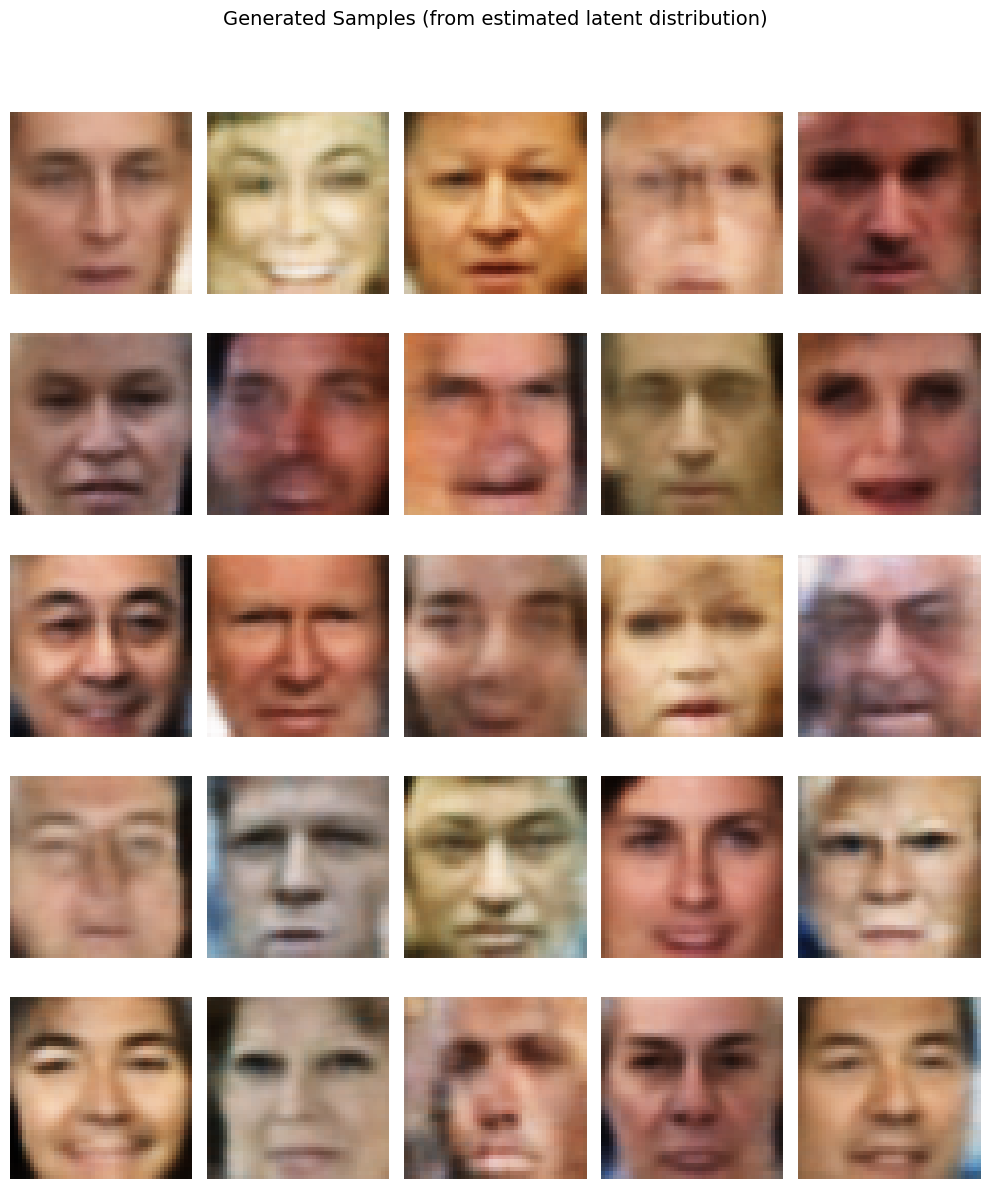

In [47]:
with torch.no_grad():
    autoencoder.eval()
    output_samples = autoencoder.decode(z_sampled)

show_generated_images(output_samples, n_to_show=25, title="Generated Samples (from estimated latent distribution)")

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [91]:
smile_train_indx = attrs_train['Smiling'].sort_values(ascending=False)[:30].index #самые улыбающиеся
smile_train_images = [images_train[i] for i in smile_train_indx]

unsmile_train_indx = attrs_train['Smiling'].sort_values(ascending=True)[:30].index #самые неулыбающиеся
unsmile_train_images = [images_train[i] for i in unsmile_train_indx]

unsmile_val_indx = attrs_val['Smiling'].sort_values(ascending=True)[:10].index #самые неулыбающиеся
unsmile_val_images = [images_val[i] for i in unsmile_val_indx]


smile_train_dataset = ImageDataset(smile_train_images, transform=train_transform)

unsmile_train_dataset = ImageDataset(unsmile_train_images, transform=train_transform)

unsmile_val_dataset = ImageDataset(unsmile_val_images, transform=test_transform)

smile_train_loader = DataLoader(smile_train_dataset, batch_size=30)

unsmile_train_loader = DataLoader(unsmile_train_dataset, batch_size=30)

unsmile_val_loader = DataLoader(unsmile_val_dataset, batch_size=10)

In [92]:
with torch.no_grad():
    smile_lat = autoencoder.encode(next(iter(smile_train_loader)).to(device))
    unsmile_lat = autoencoder.encode(next(iter(unsmile_train_loader)).to(device))

In [96]:
mean_smile_lat = smile_lat.mean(dim=0)
mean_unsmile_lat = unsmile_lat.mean(dim=0)
unsmile_to_smile_lat = mean_smile_lat - mean_unsmile_lat

In [101]:
def make_smile(autoencoder, loader, device, n_images=10, figsize=(8, None), main_title="Unsmile vs. Smile"):
    autoencoder.eval()
    orig_images = []
    recon_images = []

    with torch.no_grad():
        images_collected = 0
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                batch_images = batch[0].to(device)
            else:
                batch_images = batch.to(device)

            latent = autoencoder.encode(batch_images)
            smile_latent = latent + unsmile_to_smile_lat
            reconstruction = autoencoder.decode(smile_latent)
            batch_size = batch_images.shape[0]
            needed_now = n_images - images_collected
            take_from_batch = min(batch_size, needed_now)

            orig_images.extend(batch_images[:take_from_batch])
            recon_images.extend(reconstruction[:take_from_batch])

            images_collected += take_from_batch

            if images_collected >= n_images:
                break

    fig_w, fig_h = figsize
    if fig_h is None:
       fig_h = 2.5 * n_images
    fig, axes = plt.subplots(n_images, 2, figsize=(fig_w, fig_h))

    if n_images == 1:
        axes = np.array([axes])

    for i in range(n_images):
        orig_tensor = orig_images[i]
        recon_tensor = recon_images[i]

        img_orig_np = orig_tensor.cpu().detach().numpy()
        if img_orig_np.shape[0] in [1, 3]:
             img_orig_np = img_orig_np.transpose(1, 2, 0)
        img_orig_np = np.clip(img_orig_np, 0, 1)

        img_rec_np = recon_tensor.cpu().detach().numpy()
        if img_rec_np.shape[0] in [1, 3]:
             img_rec_np = img_rec_np.transpose(1, 2, 0)
        img_rec_np = np.clip(img_rec_np, 0, 1)


        ax_orig = axes[i, 0]
        ax_orig.imshow(img_orig_np)
        ax_orig.axis('off')
        if i == 0:
            ax_orig.set_title('Unsmile')

        # Отображаем реконструкцию
        ax_rec = axes[i, 1]
        ax_rec.imshow(img_rec_np)
        ax_rec.axis('off')
        if i == 0:
            ax_rec.set_title('Smile')

    if main_title:
        fig.suptitle(main_title, fontsize=14)

    plt.tight_layout(rect=[0, 0.01, 1, 0.96] if main_title else None)
    plt.show()


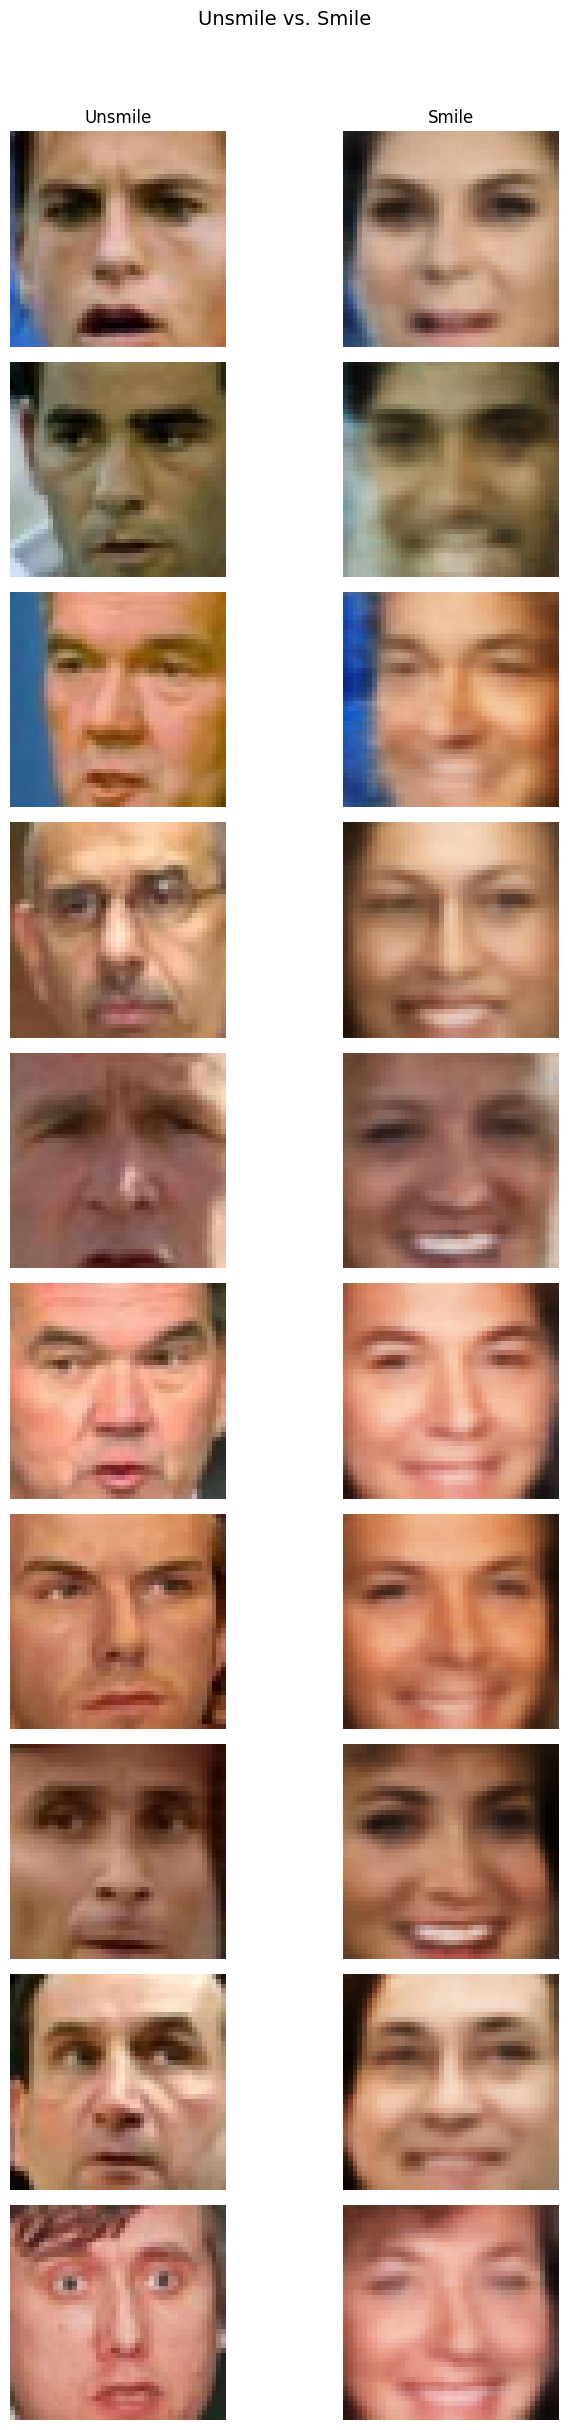

In [102]:
make_smile(autoencoder, unsmile_val_loader, device)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [30]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [47]:
class VAE(nn.Module):
    def __init__(self, input_channels=1, img_h=28, img_w=28, z_dim=8):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.img_h = img_h
        self.img_w = img_w
        self.input_channels = input_channels
        self.z_dim = z_dim
        
        self.conv_encoder = nn.Sequential(
            # Input: B, 1, 28, 28
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1), # B, 32, 14, 14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # B, 64, 7, 7
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # B, 128, 4, 4
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Рассчитываем размер после сверток
        self.flattened_size = self._get_conv_output_size(input_channels, img_h, img_w)

        # Энкодер - Bottleneck
        self.fc_encoder = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim * 2)
        )

        # Декодер - Bottleneck
        self.fc_decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.flattened_size),
            nn.ReLU()
        )

        self.conv_decoder = nn.Sequential(
             # Из B, 128, 4, 4 -> B, 64, 7, 7
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # Из B, 64, 7, 7 -> B, 32, 14, 14
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # Из B, 32, 14, 14 -> B, 1, 28, 28
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Sigmoid()
        )


    def _get_conv_output_size(self, input_channels, h, w):
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, h, w)
            output = self.conv_encoder(dummy_input)
            self.conv_output_shape = output.shape
            return int(np.prod(output.shape[1:]))

    def encode(self, x):
        x = self.conv_encoder(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_encoder(x)
        mu, logsigma = torch.chunk(x, 2, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(x.size(0), *self.conv_output_shape[1:])
        reconstruction = self.conv_decoder(x)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [21]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [56]:
def train_mnist(model, optimizer, criterion, scheduler, train_loader, val_loader=None, num_epoch=10, show_img_every = 5):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epoch)):
        model.train()
        train_losses_per_epoch = []
        for batch, label in train_loader:
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(batch.to(device))
            loss = criterion(batch.to(device), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))
        
        if val_loader is not None:
            model.eval()
            val_losses_per_epoch = []
            with torch.no_grad():
                for batch, label in val_loader:
                    mu, logsigma, reconstruction = model(batch.to(device))
                    loss = criterion(batch.to(device), mu, logsigma, reconstruction)
                    val_losses_per_epoch.append(loss.item())
    
            val_losses.append(np.mean(val_losses_per_epoch))
            scheduler.step(val_losses[-1])
        else:
            val_losses.append(0)
            scheduler.step(train_losses[-1])
        
        print(f"Epoch: {epoch} Train loss: {train_losses[-1]} Val loss: {val_losses[-1]}")
        if epoch % show_img_every == 0:
            if val_loader is not None:
                batch_for_vis, label = next(iter(val_loader))
                batch_for_vis = batch_for_vis.to(device)
            else:
                batch_for_vis, label = next(iter(train_loader))
                batch_for_vis = batch_for_vis.to(device)
            with torch.no_grad():
                 mu, logsigma, reconstruction_vis = model(batch_for_vis)
            idx_to_show = random.randint(0, batch_for_vis.shape[0] - 1)
            img_orig_tensor = batch_for_vis[idx_to_show]
            img_rec_tensor = reconstruction_vis[idx_to_show]

            img_orig_np = img_orig_tensor.cpu().detach().numpy().transpose(1, 2, 0)
            img_rec_np = img_rec_tensor.cpu().detach().numpy().transpose(1, 2, 0)
            img_orig_np = np.clip(img_orig_np, 0, 1)
            img_rec_np = np.clip(img_rec_np, 0, 1)
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            ax1, ax2 = axes

            ax1.imshow(img_orig_np)
            ax1.set_title('Original')
            ax1.axis('off')

            ax2.imshow(img_rec_np)
            ax2.set_title('Reconstructed')
            ax2.axis('off')

            plt.suptitle(f"Epoch {epoch+1}")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    return train_losses, val_losses



In [48]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = VAE().to(device)

optimizer = optim.AdamW(autoencoder.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 Train loss: 3387.006904557292 Val loss: 3216.915036722494


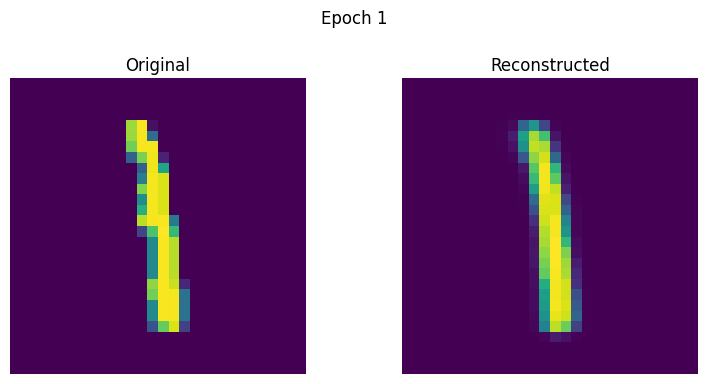

Epoch: 1 Train loss: 3351.4074102864583 Val loss: 3217.629913232578
Epoch: 2 Train loss: 3324.311315234375 Val loss: 3200.1095466004394
Epoch: 3 Train loss: 3301.069077734375 Val loss: 3162.39151966229
Epoch: 4 Train loss: 3279.7415625 Val loss: 3156.8868076702274
Epoch: 5 Train loss: 3262.805706640625 Val loss: 3130.368954984525
Epoch: 6 Train loss: 3246.9518173177084 Val loss: 3121.604150156624
Epoch: 7 Train loss: 3236.6188102864585 Val loss: 3122.595486284445
Epoch: 8 Train loss: 3222.0485989583335 Val loss: 3128.773175419329
Epoch: 9 Train loss: 3212.615944401042 Val loss: 3113.0382739179813
Epoch: 10 Train loss: 3201.506695182292 Val loss: 3110.159957349491


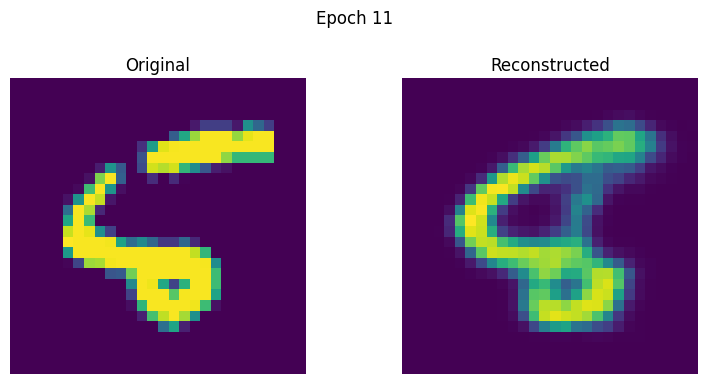

Epoch: 11 Train loss: 3193.0904131510415 Val loss: 3103.0382158078323
Epoch: 12 Train loss: 3184.2996178385415 Val loss: 3092.790351843301
Epoch: 13 Train loss: 3176.2174432291667 Val loss: 3110.8707326090753
Epoch: 14 Train loss: 3168.1746462239585 Val loss: 3097.1322033184406
Epoch: 15 Train loss: 3162.025405729167 Val loss: 3092.413271577975
Epoch: 16 Train loss: 3155.3188377604165 Val loss: 3081.9371002489765
Epoch: 17 Train loss: 3148.974123307292 Val loss: 3073.5459795577076
Epoch: 18 Train loss: 3143.539592708333 Val loss: 3075.6060646715255
Epoch: 19 Train loss: 3137.6532615885417 Val loss: 3064.53151559068
Epoch: 20 Train loss: 3133.6757009114585 Val loss: 3071.4222700710116


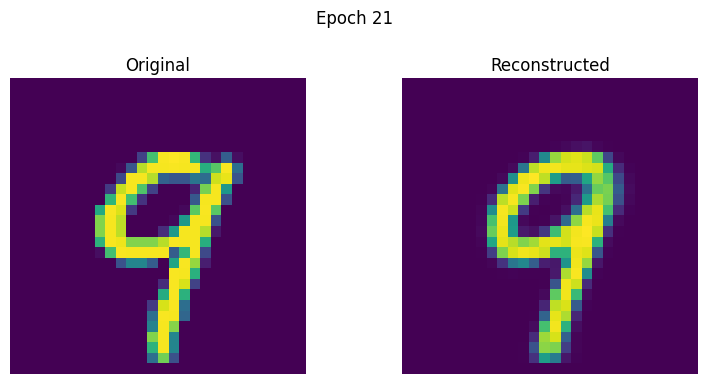

Epoch: 21 Train loss: 3128.4450268229166 Val loss: 3073.977850283297
Epoch: 22 Train loss: 3123.1560907552084 Val loss: 3062.0702212397664
Epoch: 23 Train loss: 3118.154327864583 Val loss: 3061.7542900109825
Epoch: 24 Train loss: 3114.894623046875 Val loss: 3075.2049385046425
Epoch: 25 Train loss: 3110.477509765625 Val loss: 3064.146274164462
Epoch: 26 Train loss: 3106.180464713542 Val loss: 3061.733481897714
Epoch: 27 Train loss: 3102.9432196614584 Val loss: 3061.956044157473
Epoch: 28 Train loss: 3098.58513984375 Val loss: 3074.5290098342653
Epoch: 29 Train loss: 3093.9088411458333 Val loss: 3057.943124204398
Epoch: 30 Train loss: 3092.1710369791667 Val loss: 3052.196853393945


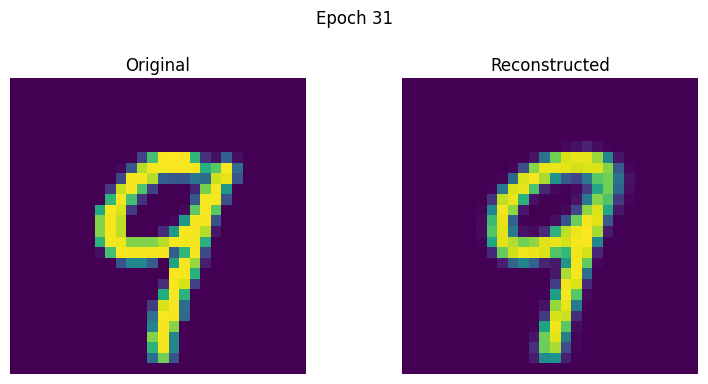

Epoch: 31 Train loss: 3087.968724739583 Val loss: 3056.0614243772466
Epoch: 32 Train loss: 3085.8110811197917 Val loss: 3054.911864454373
Epoch: 33 Train loss: 3082.684055989583 Val loss: 3071.744550126048
Epoch: 34 Train loss: 3078.821243359375 Val loss: 3054.6555476082017
Epoch: 35 Train loss: 3075.8034591145833 Val loss: 3050.3370150727587
Epoch: 36 Train loss: 3073.4036984375 Val loss: 3056.8783079884684
Epoch: 37 Train loss: 3070.843338671875 Val loss: 3057.1207856492115
Epoch: 38 Train loss: 3067.46243515625 Val loss: 3040.320019999251
Epoch: 39 Train loss: 3064.747130859375 Val loss: 3055.4827993959666
Epoch: 40 Train loss: 3061.9963428385418 Val loss: 3056.063682483027


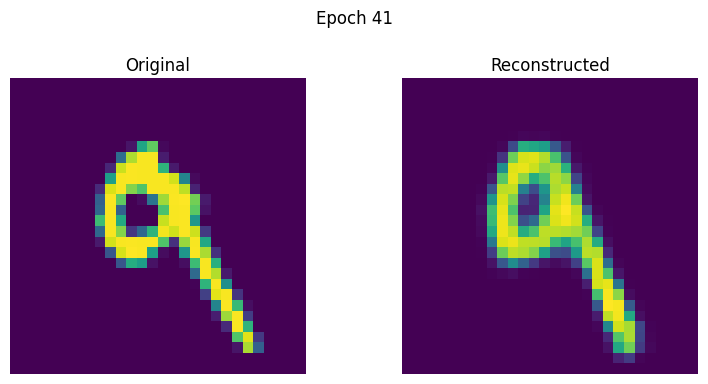

Epoch: 41 Train loss: 3060.5025557291665 Val loss: 3048.232654315595
Epoch: 42 Train loss: 3057.7602678385415 Val loss: 3056.678294416434
Epoch: 43 Train loss: 3055.255521223958 Val loss: 3044.5657791283948
Epoch: 44 Train loss: 3052.1328404947917 Val loss: 3048.8176394331567
Epoch: 45 Train loss: 3018.4510805989585 Val loss: 3030.348316911691
Epoch: 46 Train loss: 3012.2806356770834 Val loss: 3025.401069226737
Epoch: 47 Train loss: 3010.7673970052083 Val loss: 3028.938707443091
Epoch: 48 Train loss: 3008.825982682292 Val loss: 3029.461111440445
Epoch: 49 Train loss: 3007.6126915364584 Val loss: 3031.750477751223
Epoch: 50 Train loss: 3005.3793506510415 Val loss: 3027.479768308207


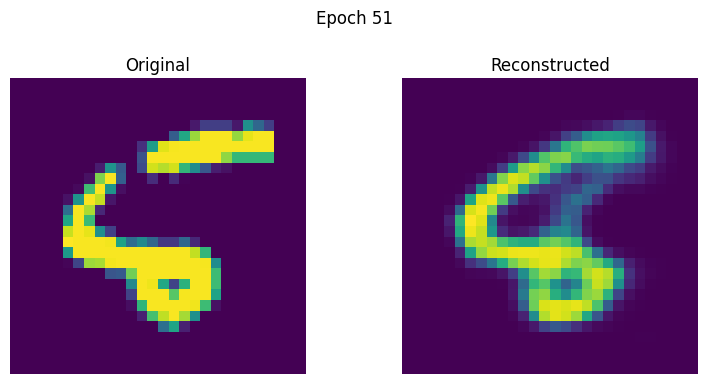

Epoch: 51 Train loss: 3003.6231860677085 Val loss: 3032.594709402456
Epoch: 52 Train loss: 3002.32708203125 Val loss: 3033.5929933980633
Epoch: 53 Train loss: 2984.8908723958334 Val loss: 3024.3929486259485
Epoch: 54 Train loss: 2981.8231671875 Val loss: 3025.8885806147664
Epoch: 55 Train loss: 2980.70890703125 Val loss: 3023.9515205358925
Epoch: 56 Train loss: 2978.5847696614583 Val loss: 3023.636715239991
Epoch: 57 Train loss: 2978.7774399739583 Val loss: 3025.413036407373
Epoch: 58 Train loss: 2977.663444140625 Val loss: 3024.5513643014924
Epoch: 59 Train loss: 2977.3489459635416 Val loss: 3026.355020248852
Epoch: 60 Train loss: 2975.401743619792 Val loss: 3028.6412213115264


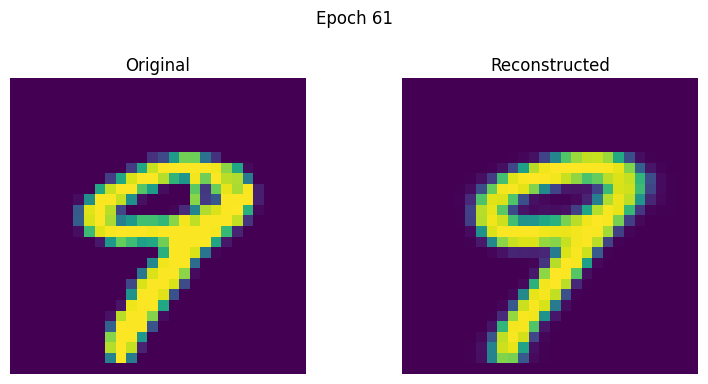

Epoch: 61 Train loss: 2975.3577571614583 Val loss: 3028.7337853184904
Epoch: 62 Train loss: 2974.542073828125 Val loss: 3027.698668848592
Epoch: 63 Train loss: 2965.2681955729167 Val loss: 3022.8426884172823
Epoch: 64 Train loss: 2963.4474005208335 Val loss: 3026.782983944439
Epoch: 65 Train loss: 2962.9369760416666 Val loss: 3023.2405923959163
Epoch: 66 Train loss: 2962.7579563802083 Val loss: 3023.971193746256
Epoch: 67 Train loss: 2961.98782578125 Val loss: 3024.2091563654403
Epoch: 68 Train loss: 2961.207354296875 Val loss: 3024.1067974834014
Epoch: 69 Train loss: 2961.464566015625 Val loss: 3024.0230580290286
Epoch: 70 Train loss: 2956.8868908854165 Val loss: 3024.7807188186403


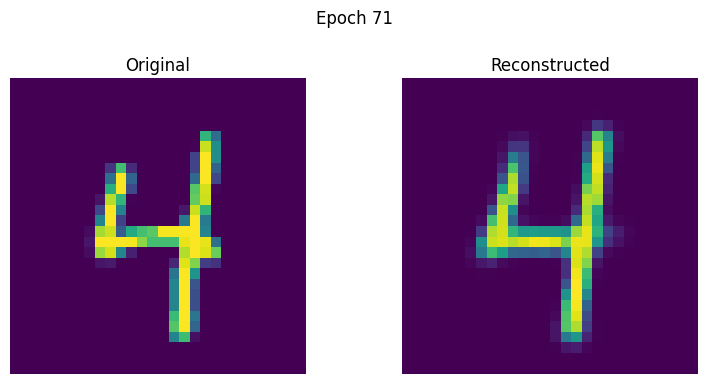

Epoch: 71 Train loss: 2955.8501166666665 Val loss: 3023.193399935104
Epoch: 72 Train loss: 2955.4464430989583 Val loss: 3024.8455135845147
Epoch: 73 Train loss: 2954.459727604167 Val loss: 3024.765910480731
Epoch: 74 Train loss: 2955.77699921875 Val loss: 3026.626740184455
Epoch: 75 Train loss: 2954.893732421875 Val loss: 3021.827371908072
Epoch: 76 Train loss: 2953.6499227864583 Val loss: 3023.8753892209966
Epoch: 77 Train loss: 2953.690928125 Val loss: 3025.280315947609
Epoch: 78 Train loss: 2953.8913109375 Val loss: 3027.1191531050317
Epoch: 79 Train loss: 2953.3517334635417 Val loss: 3024.5543103690347
Epoch: 80 Train loss: 2953.4645763020835 Val loss: 3025.490985516923


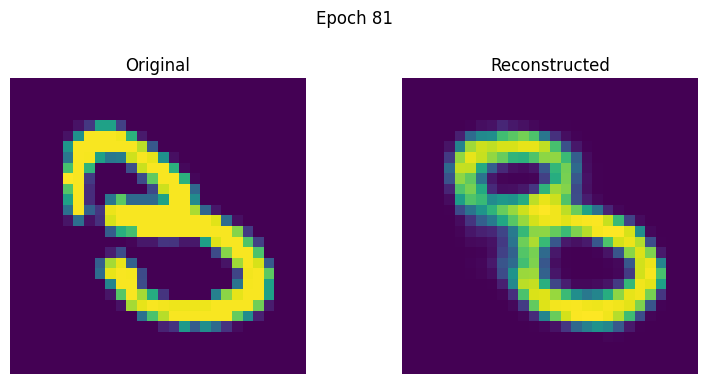

Epoch: 81 Train loss: 2952.97134453125 Val loss: 3023.518776988069
Epoch: 82 Train loss: 2951.2074743489584 Val loss: 3027.2503872709913
Epoch: 83 Train loss: 2950.59545 Val loss: 3025.708291733227
Epoch: 84 Train loss: 2949.6521209635416 Val loss: 3024.5389724097695
Epoch: 85 Train loss: 2949.6538391927083 Val loss: 3028.6176340511433
Epoch: 86 Train loss: 2949.6981126302085 Val loss: 3027.2806029883436
Epoch: 87 Train loss: 2948.8149169270832 Val loss: 3024.8038306678063
Epoch: 88 Train loss: 2949.06425234375 Val loss: 3025.552530014477
Epoch: 89 Train loss: 2948.742976953125 Val loss: 3025.2508197820985
Epoch: 90 Train loss: 2947.9003498697916 Val loss: 3025.277126129443


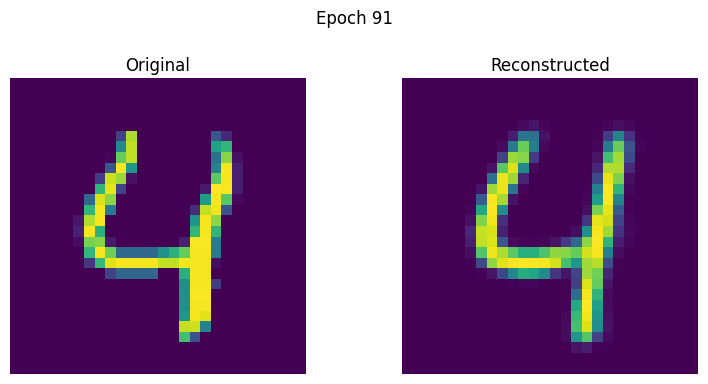

Epoch: 91 Train loss: 2948.2520580729165 Val loss: 3025.8332893932206
Epoch: 92 Train loss: 2947.6868296875 Val loss: 3026.1116405157995
Epoch: 93 Train loss: 2947.5776578125 Val loss: 3024.9447797586363
Epoch: 94 Train loss: 2947.21140234375 Val loss: 3024.276840648712
Epoch: 95 Train loss: 2947.9312141927085 Val loss: 3028.0878695649462
Epoch: 96 Train loss: 2946.9055108072916 Val loss: 3025.9039306640625
Epoch: 97 Train loss: 2947.5554751302084 Val loss: 3025.5432760707868
Epoch: 98 Train loss: 2947.4026438802084 Val loss: 3025.31467191556
Epoch: 99 Train loss: 2946.703660286458 Val loss: 3025.9627104445385


In [57]:
train_loss, val_loss = train_mnist(autoencoder, optimizer, criterion, scheduler, train_loader, val_loader = test_loader, num_epoch=100, show_img_every=10)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [59]:
def show_reconstructions_from_loader_vae(model, loader, device, n_images=5, figsize=(8, None), main_title="Original vs. Reconstructed Images"):
    model.eval()
    orig_images = []
    recon_images = []

    with torch.no_grad():
        images_collected = 0
        for batch, label in loader:
            if isinstance(batch, (list, tuple)):
                batch_images = batch[0].to(device)
            else:
                batch_images = batch.to(device)

            mu, logsigma, reconstruction = model(batch_images)
            batch_size = batch_images.shape[0]
            needed_now = n_images - images_collected
            take_from_batch = min(batch_size, needed_now)

            orig_images.extend(batch_images[:take_from_batch])
            recon_images.extend(reconstruction[:take_from_batch])

            images_collected += take_from_batch

            if images_collected >= n_images:
                break

    fig_w, fig_h = figsize
    if fig_h is None:
       fig_h = 2.5 * n_images
    fig, axes = plt.subplots(n_images, 2, figsize=(fig_w, fig_h))

    if n_images == 1:
        axes = np.array([axes]) # Делаем его (1, 2)

    for i in range(n_images):
        orig_tensor = orig_images[i]
        recon_tensor = recon_images[i]

        img_orig_np = orig_tensor.cpu().detach().numpy()
        if img_orig_np.shape[0] in [1, 3]:
             img_orig_np = img_orig_np.transpose(1, 2, 0)
        img_orig_np = np.clip(img_orig_np, 0, 1)

        img_rec_np = recon_tensor.cpu().detach().numpy()
        if img_rec_np.shape[0] in [1, 3]:
             img_rec_np = img_rec_np.transpose(1, 2, 0)
        img_rec_np = np.clip(img_rec_np, 0, 1)


        ax_orig = axes[i, 0]
        ax_orig.imshow(img_orig_np)
        ax_orig.axis('off')
        if i == 0:
            ax_orig.set_title('Original')

        # Отображаем реконструкцию
        ax_rec = axes[i, 1]
        ax_rec.imshow(img_rec_np)
        ax_rec.axis('off')
        if i == 0:
            ax_rec.set_title('Reconstructed')

    if main_title:
        fig.suptitle(main_title, fontsize=14)

    plt.tight_layout(rect=[0, 0.01, 1, 0.96] if main_title else None)
    plt.show()


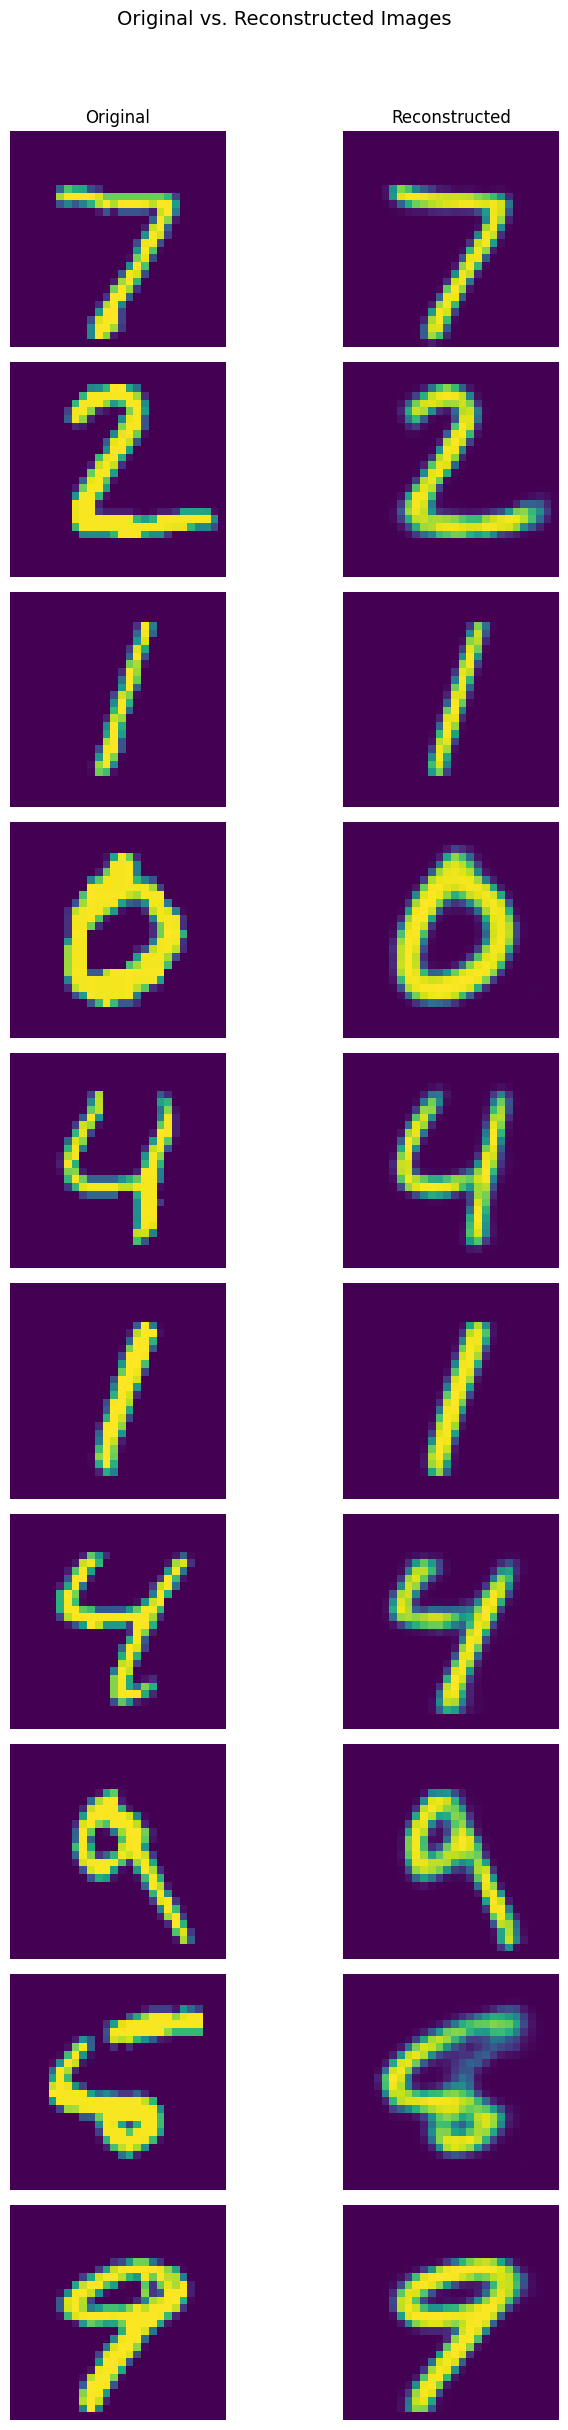

In [60]:
show_reconstructions_from_loader_vae(autoencoder, test_loader, device, 10)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [81]:
all_mu_list = []
all_sigma_list = []
with torch.no_grad():
    for batch_data, _ in tqdm(train_loader): 
        batch = batch_data.to(device)
        mu, logsigma = autoencoder.encode(batch) 
        sigma = torch.exp(0.5 * logsigma)

        if mu.dim() > 2:
            mu = mu.view(mu.size(0), -1)
        if sigma.dim() > 2:
            sigma = sigma.view(sigma.size(0), -1)

        all_mu_list.append(mu.cpu().numpy())
        all_sigma_list.append(sigma.cpu().numpy())

all_mu_np = np.concatenate(all_mu_list, axis=0)
all_sigma_np = np.concatenate(all_sigma_list, axis=0)

mu_real = np.mean(all_mu_np, axis=0)
std_real = np.mean(all_sigma_np, axis=0) 
print(f"Shape of mu_real: {mu_real.shape}")
print(f"Shape of std_real: {std_real.shape}")

  0%|          | 0/1875 [00:00<?, ?it/s]

Shape of mu_real: (8,)
Shape of std_real: (8,)


In [86]:
num_samples = 25
z_dim = mu_real.shape[0] 
z_sampled_np = np.zeros((num_samples, z_dim))
for i in range(z_dim):
    z_sampled_np[:, i] = np.random.normal(loc=mu_real[i], scale=std_real[i], size=num_samples)

z_sampled = torch.FloatTensor(z_sampled_np).to(device)

print(f"Shape of sampled z: {z_sampled.shape}")

with torch.no_grad():
    autoencoder.eval()
    output_samples = autoencoder.decode(z_sampled)

Shape of sampled z: torch.Size([25, 8])


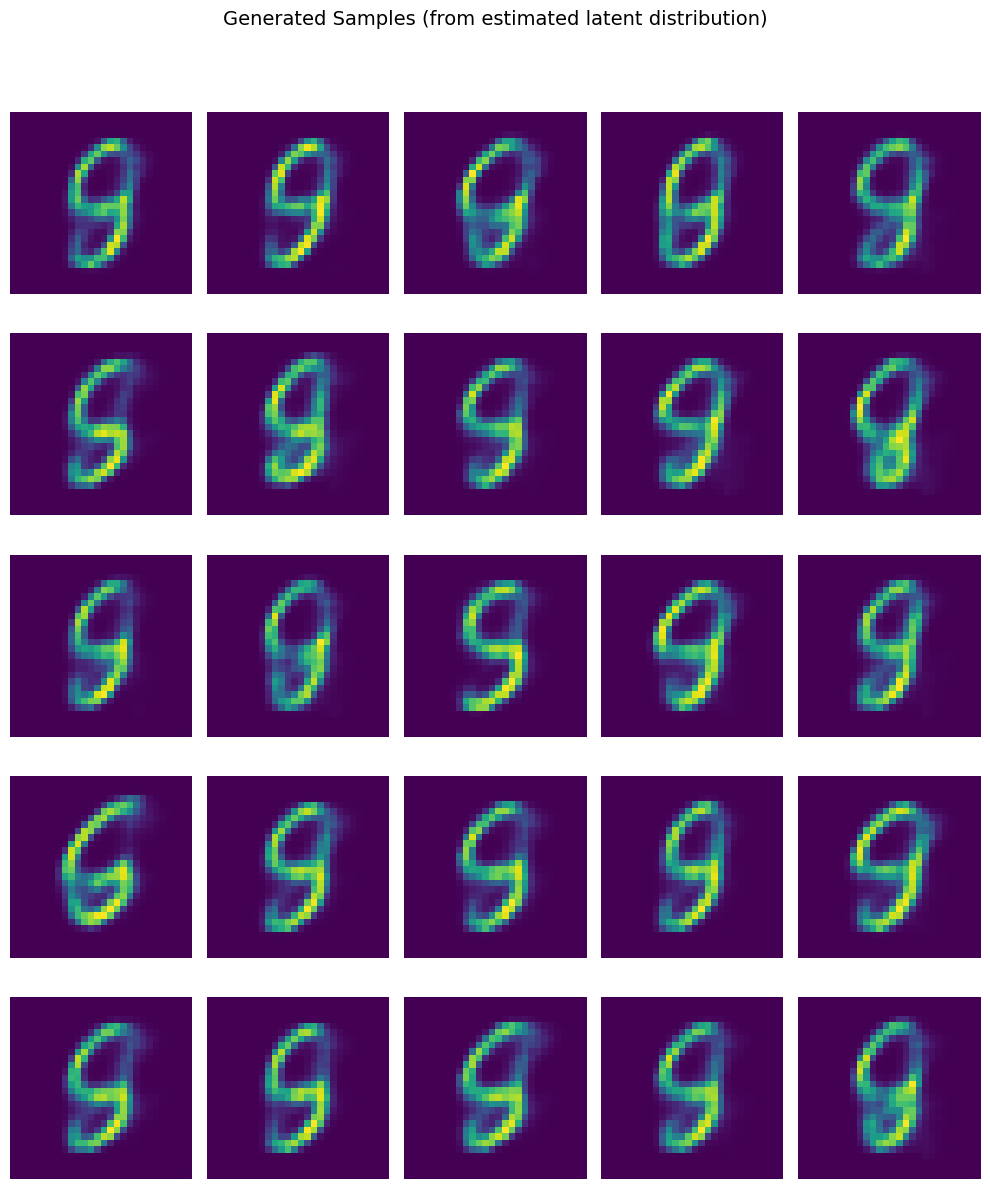

In [87]:
show_generated_images(output_samples, n_to_show=25, title="Generated Samples (from estimated latent distribution)")

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [93]:
from sklearn.manifold import TSNE

def visualize_latent_space_vae(model, loader, device, n_samples=None):
    model.eval()
    latents_mu = []
    labels = []
    with torch.no_grad():
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            mu, logsigma = model.encode(batch)
            latents_mu.append(mu.cpu().numpy())
            labels.append(label.numpy())

    # Объединяем списки массивов в один большой массив
    latents_mu = np.concatenate(latents_mu, axis=0)
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300, init='pca', learning_rate='auto')
    latents_2d = tsne.fit_transform(latents_mu)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.colorbar(scatter, label='Digit Class', ticks=range(10))
    plt.title('t-SNE Visualization of MNIST Latent Space (VAE)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


  0%|          | 0/1875 [00:00<?, ?it/s]

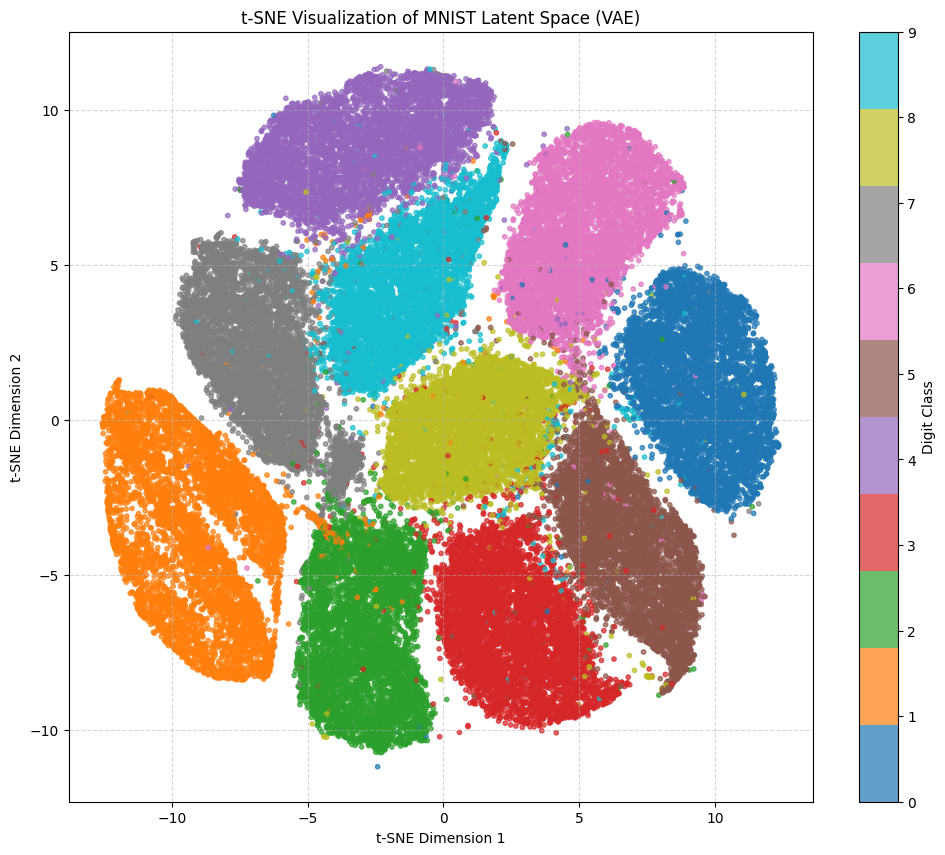

In [94]:
visualize_latent_space_vae(autoencoder, train_loader, device)

Что вы думаете о виде латентного представления?

очень заметно разделены кластеры точек в зависимости от класса

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [138]:
class CVAE(nn.Module):
    def __init__(self, input_channels=1, img_h=28, img_w=28, z_dim=8, num_classes=10):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.img_h = img_h
        self.img_w = img_w
        self.input_channels = input_channels
        self.z_dim = z_dim
        self.num_classes = num_classes
        
        self.conv_encoder = nn.Sequential(
            # Input: B, 1, 28, 28
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1), # B, 32, 14, 14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # B, 64, 7, 7
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # B, 128, 4, 4
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Рассчитываем размер после сверток
        self.flattened_size = self._get_conv_output_size(input_channels, img_h, img_w)

        # Энкодер - Bottleneck
        self.fc_encoder = nn.Sequential(
            nn.Linear(self.flattened_size + self.num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim * 2) 
        )

        # Декодер - Bottleneck
        self.fc_decoder = nn.Sequential(
            nn.Linear(z_dim + self.num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, self.flattened_size),
            nn.ReLU()
        )

        self.conv_decoder = nn.Sequential(
             # B, 64, 7, 7
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            #  B, 32, 14, 14
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # B, 1, 28, 28
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Sigmoid()
        )


    def _get_conv_output_size(self, input_channels, h, w):
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, h, w)
            output = self.conv_encoder(dummy_input)
            self.conv_output_shape = output.shape
            return int(np.prod(output.shape[1:]))

    
    def encode(self, x, y_onehot):
        # <реализуйте forward проход энкодера
        # в качестве возвращаемых переменных -- mu, logsigma и класс картинки>
        conv_out = self.conv_encoder(x)
        conv_flat = conv_out.view(conv_out.size(0), -1)
        fc_input = torch.cat((conv_flat, y_onehot.to(conv_flat.device)), dim=1)
        h = self.fc_encoder(fc_input)
        mu, logsigma = torch.chunk(h, 2, dim=1)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, y_onehot):
        fc_input = torch.cat((z, y_onehot.to(z.device)), dim=1)
        h = self.fc_decoder(fc_input)
        conv_input = h.view(h.size(0), *self.conv_output_shape[1:])
        reconstruction = self.conv_decoder(conv_input)
        return reconstruction

    def forward(self, x, class_num):
        # используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        y_onehot = F.one_hot(class_num, num_classes=self.num_classes).float().to(x.device)

        mu, logsigma = self.encode(x, y_onehot)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, y_onehot)

        return mu, logsigma, reconstruction

    def sample(self, num_samples, class_num, device='cpu'):
        self.eval()
        with torch.no_grad():
            z = torch.randn(num_samples, self.z_dim).to(device)
            y_label = torch.tensor([class_num] * num_samples, device=device)
            y_onehot = F.one_hot(y_label, num_classes=self.num_classes).float()
            samples = self.decode(z, y_onehot)
        return samples

In [146]:
def train_mnist_cvae(model, optimizer, criterion, scheduler, train_loader, val_loader=None, num_epoch=10, show_img_every = 5):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epoch)):
        model.train()
        train_losses_per_epoch = []
        for batch, label in train_loader:
            batch, label = batch.to(device), label.to(device)
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(batch, label)
            loss = criterion(batch, mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))
        
        if val_loader is not None:
            model.eval()
            val_losses_per_epoch = []
            with torch.no_grad():
                for batch, label in val_loader:
                    batch, label = batch.to(device), label.to(device)
                    mu, logsigma, reconstruction = model(batch, label)
                    loss = criterion(batch, mu, logsigma, reconstruction)
                    val_losses_per_epoch.append(loss.item())
    
            val_losses.append(np.mean(val_losses_per_epoch))
            scheduler.step(val_losses[-1])
        else:
            val_losses.append(0)
            scheduler.step(train_losses[-1])
        
        print(f"Epoch: {epoch} Train loss: {train_losses[-1]} Val loss: {val_losses[-1]}")
        if (epoch + 1) % show_img_every == 0:
            if val_loader is not None:
                batch_for_vis, label = next(iter(val_loader))
            else:
                batch_for_vis, label = next(iter(train_loader))
            batch_for_vis, label = batch_for_vis.to(device), label.to(device)
            with torch.no_grad():
                 mu, logsigma, reconstruction_vis = model(batch_for_vis, label)
            idx_to_show = random.randint(0, batch_for_vis.shape[0] - 1)
            img_orig_tensor = batch_for_vis[idx_to_show]
            img_rec_tensor = reconstruction_vis[idx_to_show]

            img_orig_np = img_orig_tensor.cpu().detach().numpy().transpose(1, 2, 0)
            img_rec_np = img_rec_tensor.cpu().detach().numpy().transpose(1, 2, 0)
            img_orig_np = np.clip(img_orig_np, 0, 1)
            img_rec_np = np.clip(img_rec_np, 0, 1)
            fig, axes = plt.subplots(1, 2, figsize=(6, 4))
            ax1, ax2 = axes

            ax1.imshow(img_orig_np)
            ax1.set_title('Original')
            ax1.axis('off')

            ax2.imshow(img_rec_np)
            ax2.set_title('Reconstructed')
            ax2.axis('off')

            plt.suptitle(f"Epoch {epoch+1}")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    return train_losses, val_losses



In [139]:
criterion = loss_vae
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = CVAE().to(device)

optimizer = optim.AdamW(autoencoder.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 Train loss: 3044.8715591145833 Val loss: 2950.8148275259587
Epoch: 1 Train loss: 3035.8270651041666 Val loss: 2959.9239579953323
Epoch: 2 Train loss: 3026.066095703125 Val loss: 2933.790547233801
Epoch: 3 Train loss: 3019.5105220052083 Val loss: 2946.2418591191595
Epoch: 4 Train loss: 3011.2099427083335 Val loss: 2949.0013880135534
Epoch: 5 Train loss: 3005.2856484375 Val loss: 2931.27444136257
Epoch: 6 Train loss: 2999.1337013020834 Val loss: 2944.6046594979284
Epoch: 7 Train loss: 2992.792266015625 Val loss: 2926.1913181097743
Epoch: 8 Train loss: 2986.7696282552083 Val loss: 2933.8724712335265
Epoch: 9 Train loss: 2980.520662109375 Val loss: 2929.128919510034


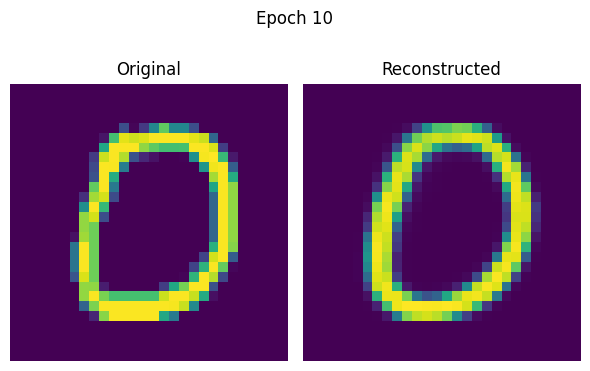

Epoch: 10 Train loss: 2975.6262014322915 Val loss: 2919.296580939247
Epoch: 11 Train loss: 2970.385368098958 Val loss: 2923.5940935908798
Epoch: 12 Train loss: 2965.5113216145833 Val loss: 2925.504896462535
Epoch: 13 Train loss: 2961.073756380208 Val loss: 2914.5866192217454
Epoch: 14 Train loss: 2956.2424893229168 Val loss: 2914.998811276957
Epoch: 15 Train loss: 2952.501799609375 Val loss: 2906.5642390144517
Epoch: 16 Train loss: 2949.236937109375 Val loss: 2911.372798054363
Epoch: 17 Train loss: 2944.5404765625 Val loss: 2924.749241448058
Epoch: 18 Train loss: 2941.1319747395833 Val loss: 2912.953128510009
Epoch: 19 Train loss: 2938.200656770833 Val loss: 2909.134189593525


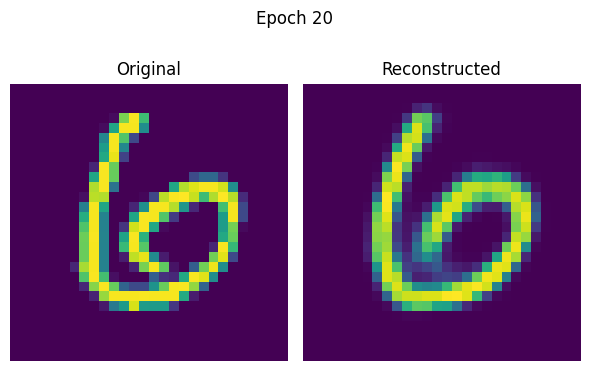

Epoch: 20 Train loss: 2934.213545052083 Val loss: 2915.9159033047126
Epoch: 21 Train loss: 2931.23607890625 Val loss: 2897.6900767365964
Epoch: 22 Train loss: 2927.250642838542 Val loss: 2903.9342072215704
Epoch: 23 Train loss: 2924.277285286458 Val loss: 2909.760202816119
Epoch: 24 Train loss: 2922.2621061197915 Val loss: 2907.7432233426516
Epoch: 25 Train loss: 2917.8617459635416 Val loss: 2914.047875352561
Epoch: 26 Train loss: 2914.4773083333334 Val loss: 2908.4039486041083
Epoch: 27 Train loss: 2912.3830983072917 Val loss: 2903.004898802541
Epoch: 28 Train loss: 2879.10488125 Val loss: 2879.907528813274
Epoch: 29 Train loss: 2873.7086415364583 Val loss: 2881.1207696591705


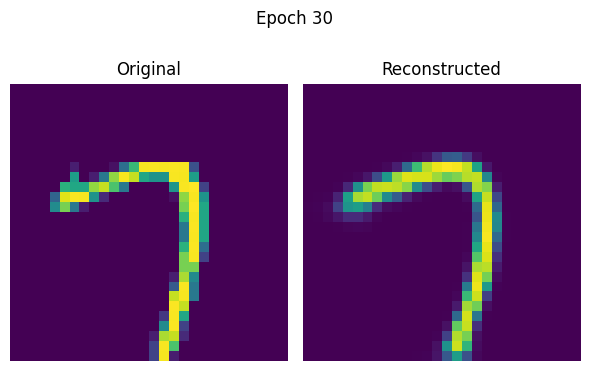

Epoch: 30 Train loss: 2872.189008203125 Val loss: 2884.345952725639
Epoch: 31 Train loss: 2870.4955248697916 Val loss: 2892.398126279203
Epoch: 32 Train loss: 2868.2063766927085 Val loss: 2886.710911759934
Epoch: 33 Train loss: 2866.552004036458 Val loss: 2887.5674881127698
Epoch: 34 Train loss: 2863.83093671875 Val loss: 2885.8955538326177
Epoch: 35 Train loss: 2848.1087080729167 Val loss: 2878.908386035468
Epoch: 36 Train loss: 2844.3076654947918 Val loss: 2879.3011197708665
Epoch: 37 Train loss: 2842.847818359375 Val loss: 2880.475268866688
Epoch: 38 Train loss: 2841.6992748697917 Val loss: 2880.6533753026406
Epoch: 39 Train loss: 2840.980881119792 Val loss: 2884.5316384409944


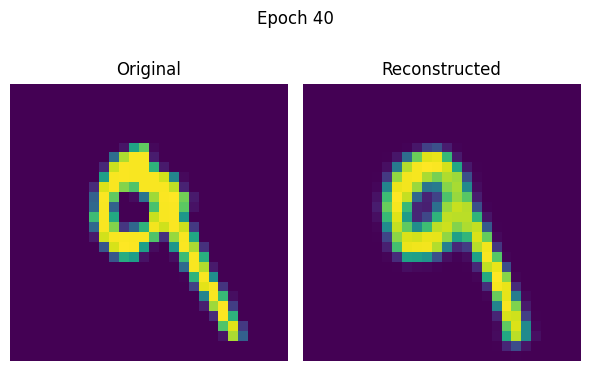

Epoch: 40 Train loss: 2840.1200540364584 Val loss: 2882.428713667507
Epoch: 41 Train loss: 2838.913720833333 Val loss: 2886.1200111072285
Epoch: 42 Train loss: 2829.8381861979165 Val loss: 2881.480936361197
Epoch: 43 Train loss: 2828.7312967447915 Val loss: 2881.482401984949
Epoch: 44 Train loss: 2828.875744010417 Val loss: 2882.1424591746954
Epoch: 45 Train loss: 2827.0297680989584 Val loss: 2879.8869211605183
Epoch: 46 Train loss: 2827.418927864583 Val loss: 2881.8095301423973
Epoch: 47 Train loss: 2825.519541015625 Val loss: 2882.8739703973642
Epoch: 48 Train loss: 2822.338828125 Val loss: 2880.507878020168
Epoch: 49 Train loss: 2820.885055078125 Val loss: 2881.128467498877


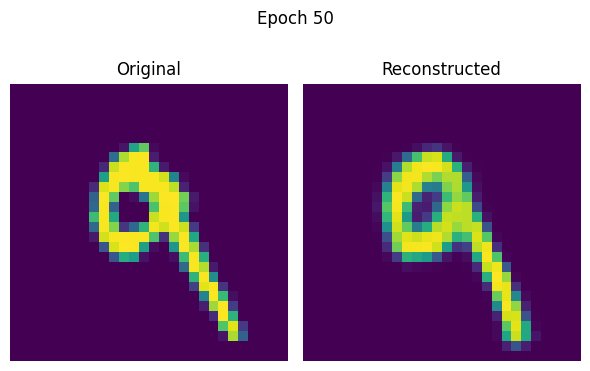

Epoch: 50 Train loss: 2820.472744401042 Val loss: 2881.95386327189
Epoch: 51 Train loss: 2820.011057421875 Val loss: 2882.0756094935605
Epoch: 52 Train loss: 2819.0382834635416 Val loss: 2880.1800525409344
Epoch: 53 Train loss: 2820.2852092447915 Val loss: 2881.9216940395368
Epoch: 54 Train loss: 2817.1934399739584 Val loss: 2881.7440977248903
Epoch: 55 Train loss: 2817.119835416667 Val loss: 2881.5441044329073
Epoch: 56 Train loss: 2816.5073149739583 Val loss: 2879.3338747847192
Epoch: 57 Train loss: 2816.767237239583 Val loss: 2880.9214709589655
Epoch: 58 Train loss: 2817.42382890625 Val loss: 2882.1594979283145
Epoch: 59 Train loss: 2817.209719791667 Val loss: 2883.0167606829073


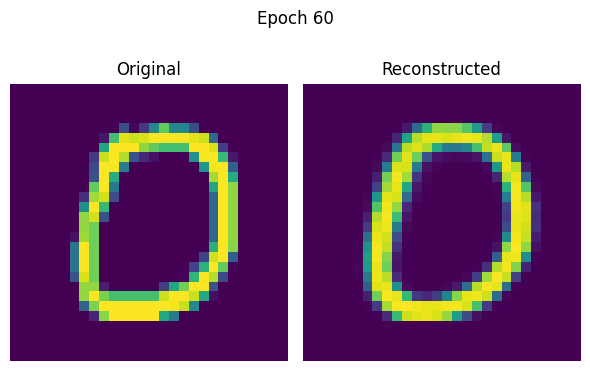

Epoch: 60 Train loss: 2815.0572385416667 Val loss: 2882.0698788188897
Epoch: 61 Train loss: 2814.5934145833335 Val loss: 2881.7575324792833
Epoch: 62 Train loss: 2814.831171484375 Val loss: 2881.0327928439497
Epoch: 63 Train loss: 2815.8529203125 Val loss: 2883.0843845160243
Epoch: 64 Train loss: 2814.349085807292 Val loss: 2881.3186994558705
Epoch: 65 Train loss: 2814.762820703125 Val loss: 2881.667065117687
Epoch: 66 Train loss: 2813.666950260417 Val loss: 2880.470397754218
Epoch: 67 Train loss: 2813.592056119792 Val loss: 2880.0311306596946
Epoch: 68 Train loss: 2814.3244625 Val loss: 2881.5259221963606
Epoch: 69 Train loss: 2813.8314388020835 Val loss: 2882.2258090180712


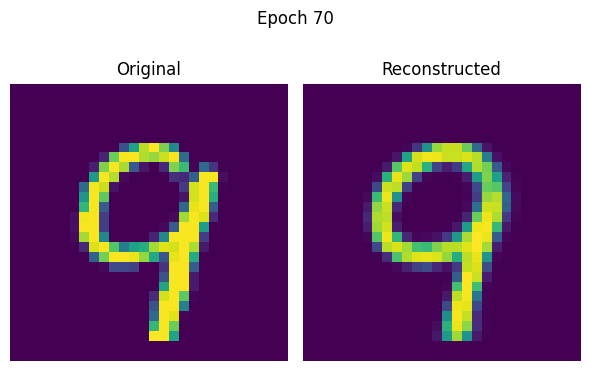

Epoch: 70 Train loss: 2813.7018850260415 Val loss: 2882.1792495288787
Epoch: 71 Train loss: 2813.7093291666665 Val loss: 2881.248259035543
Epoch: 72 Train loss: 2813.523143359375 Val loss: 2881.461226880741
Epoch: 73 Train loss: 2813.1034791666666 Val loss: 2881.9918076390277
Epoch: 74 Train loss: 2812.651603515625 Val loss: 2881.12624215318
Epoch: 75 Train loss: 2813.7192328125 Val loss: 2881.7106134091705
Epoch: 76 Train loss: 2813.3481157552083 Val loss: 2881.36603114704
Epoch: 77 Train loss: 2813.0847859375 Val loss: 2881.4378432008784
Epoch: 78 Train loss: 2813.5717510416666 Val loss: 2881.597403529353
Epoch: 79 Train loss: 2813.018111848958 Val loss: 2881.5333337753345


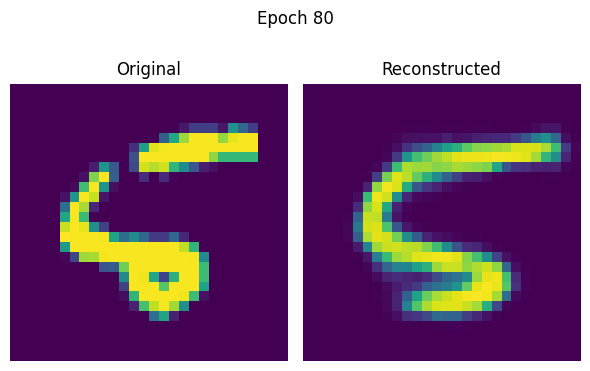

Epoch: 80 Train loss: 2813.7262420572915 Val loss: 2882.1773084939095
Epoch: 81 Train loss: 2813.6089721354165 Val loss: 2882.0364842033996
Epoch: 82 Train loss: 2812.494364583333 Val loss: 2881.8709549096448
Epoch: 83 Train loss: 2812.911751041667 Val loss: 2882.3180286541533
Epoch: 84 Train loss: 2812.966589583333 Val loss: 2881.3628986590206
Epoch: 85 Train loss: 2813.408841015625 Val loss: 2881.447436835438
Epoch: 86 Train loss: 2812.187221223958 Val loss: 2881.704885074506
Epoch: 87 Train loss: 2812.4942647135417 Val loss: 2881.1555908983128
Epoch: 88 Train loss: 2813.04476796875 Val loss: 2882.351303539337
Epoch: 89 Train loss: 2812.8961953125 Val loss: 2881.854045246356


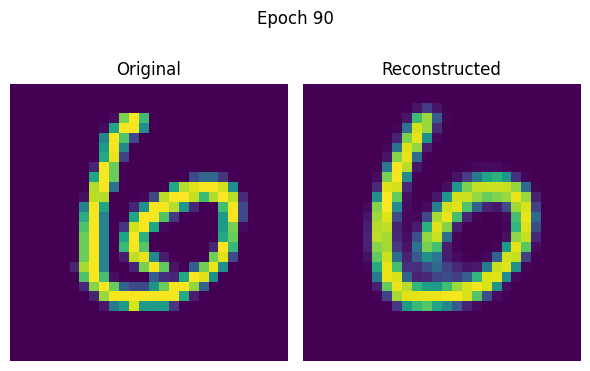

Epoch: 90 Train loss: 2812.878426692708 Val loss: 2881.977486412365
Epoch: 91 Train loss: 2812.737340625 Val loss: 2881.4689438304963
Epoch: 92 Train loss: 2813.043559505208 Val loss: 2881.702627358726
Epoch: 93 Train loss: 2812.705877734375 Val loss: 2881.674599546975
Epoch: 94 Train loss: 2813.29871015625 Val loss: 2881.1213269705972
Epoch: 95 Train loss: 2812.800143359375 Val loss: 2882.4768799608128
Epoch: 96 Train loss: 2813.203113411458 Val loss: 2882.5462623084313
Epoch: 97 Train loss: 2813.143059375 Val loss: 2882.421918680112
Epoch: 98 Train loss: 2813.4600850260417 Val loss: 2881.9222330209163
Epoch: 99 Train loss: 2812.0187139322916 Val loss: 2881.483928838858


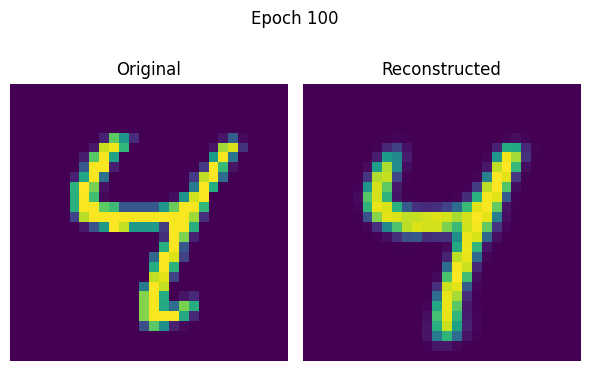

In [147]:
train_loss, val_loss = train_mnist_cvae(autoencoder, optimizer, criterion, scheduler, train_loader, val_loader = test_loader, num_epoch=100, show_img_every=10)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

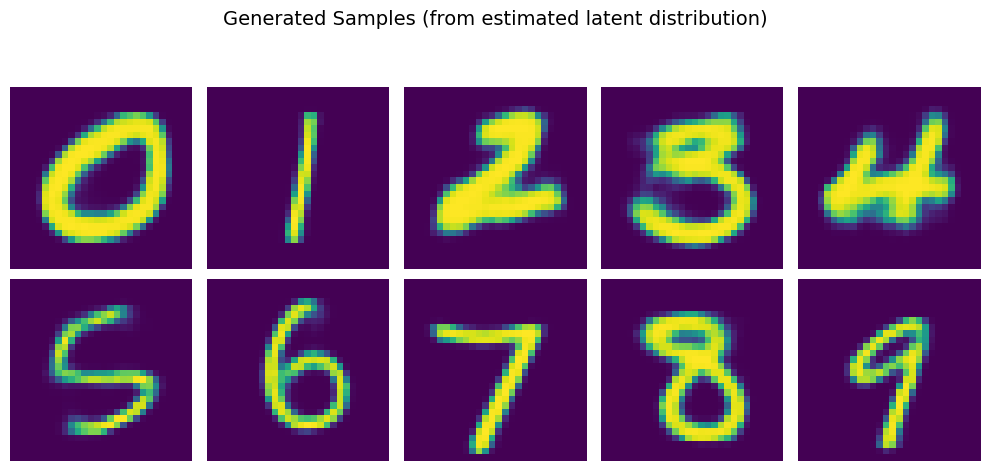

In [174]:
all_samples_list = []

autoencoder.eval()
with torch.no_grad():
    for digit in range(10):
        z = torch.randn(1, autoencoder.z_dim).to(device)

        y_label = torch.full((1,), fill_value=digit, dtype=torch.long, device=device)
        y_onehot = F.one_hot(y_label, num_classes=10).float()
        samples = autoencoder.decode(z, y_onehot)
        all_samples_list.append(samples)

all_samples_tensor = torch.cat(all_samples_list, dim=0) 

show_generated_images(all_samples_tensor, n_to_show=10, title="Generated Samples (from estimated latent distribution)")

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [175]:
def visualize_latent_space_cvae(model, loader, device):
    model.eval() # Переводим модель в режим оценки
    latents_mu = []
    labels = []
    with torch.no_grad():
        for batch, label in tqdm(loader):
            batch, label = batch.to(device), label.to(device)
            y_onehot = F.one_hot(label, num_classes=10).float().to(device)
            mu, logsigma = model.encode(batch, y_onehot)
            latents_mu.append(mu.cpu().numpy())
            labels.append(label.cpu().numpy())

    # Объединяем списки массивов в один большой массив
    latents_mu = np.concatenate(latents_mu, axis=0)
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300, init='pca', learning_rate='auto')
    latents_2d = tsne.fit_transform(latents_mu)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.colorbar(scatter, label='Digit Class', ticks=range(10))
    plt.title('t-SNE Visualization of MNIST Latent Space (CVAE)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


  0%|          | 0/1875 [00:00<?, ?it/s]

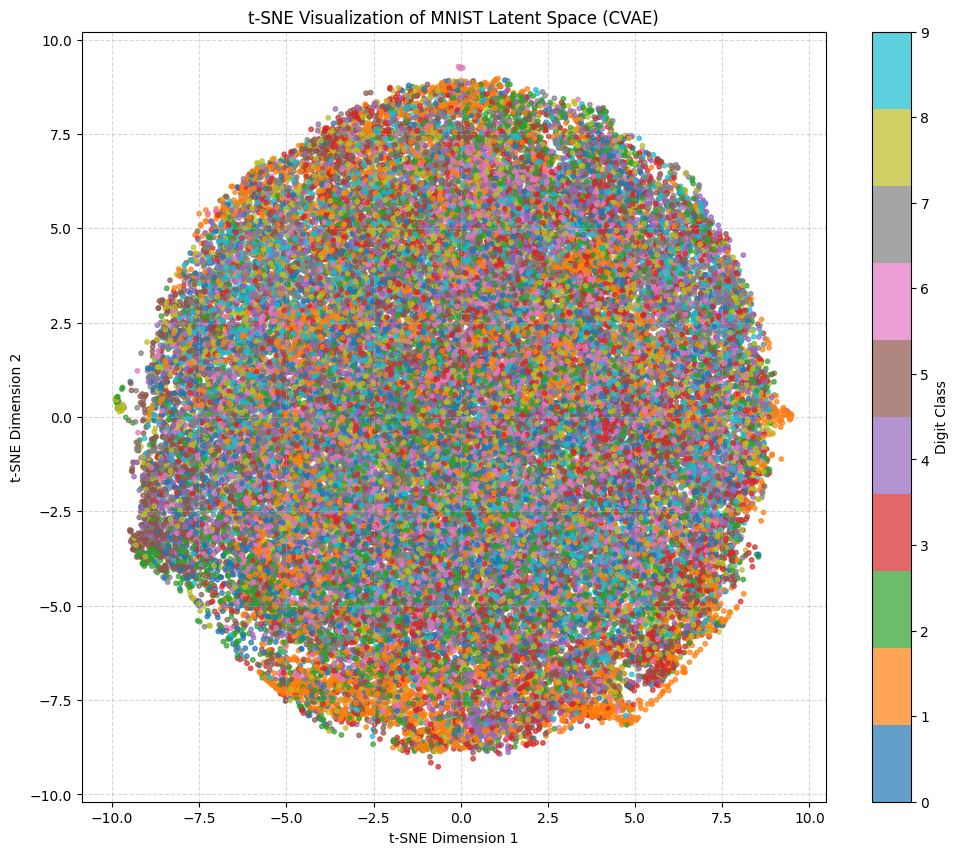

In [176]:
visualize_latent_space_cvae(autoencoder, train_loader, device)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

здесь уже нет никаких кластеров, все точки перемешаны, что позволят из одного латентного вектора получать различные классы(цифры), добавляя разные oh вектора классов

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>